# Project : Airline on-time performance (exploratory analysis)

<a id="toc"></a>

## Table of Contents

* [Introduction](#intro)
* [Preliminary Data Wrangling](#wrangling)
* [Exploratory Data Analysis](#eda)
* [Conclusions](#conclusion)

<a id="intro"></a>

[TOC](#intro)               
## Introduction

We are going to investigate flight datasets in order to gain insights on airline on-time performance from 2005 to 2008. The goal is to understand reasons that tend to make a flight delayed or cancelled. In particular, we will be intersted in the following key questions:

* Are there certain departure cities that are home to more delays or cancellations?
* What are the preferred periods for flights to occur ? 
* When is the best day of week or month of year to fly to minimise delays ?
* Are there any changes over multiple years?
* Do older planes suffer more delays?
* How well does weather predict plane delays?


We are going to explore the data while having three identities in mind:
* a passenger, who want to know before hand if he may be stuck in an airport waiting for his flight, and plan accordingly.
* an airport administrative, who want to understand issues causing delay, in order to know what he can work on so that he improve the aiport performance.
* a freight company administrative, who also want to understand issues causing delay, in order to know which aspect of his planes he should take note of so that he improve his planes performance.
                     
                     
                       

> **Report date : February, 2023**     
> **Written by : [Ekoue LOGOSU-TEKO](https://www.linkedin.com/in/ekouelogosuteko/?locale=en_US)**



In [1]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from dateutil.parser import parse
from datetime import datetime

from typing import List, Tuple

%matplotlib inline

In [2]:
def plot_matrice(df:pd.DataFrame, x_vars:List[str], y_vars:List[str])->None:
    
    """ 
        Make a plot matrice of x_vars by y_vars 
    
        @params:
            - x_vars: list of strings; contains the features to be plotted on the x-axis
            - y_vars: list of strings; contains the features to be plotted on the y-axis
            
        @return None
    """
    
    def boxgrid(x, y, **kwargs):
        """ Quick hack for creating box plots with seaborn's PairGrid. """
        default_color = sb.color_palette()[0]
        sb.boxplot(x=x, y=y, color=default_color)

    plt.figure(figsize = [10, 20])
    g = sb.PairGrid(data = df , y_vars = y_vars, x_vars = x_vars,
                    size = 3, aspect = 1.5)
    g.map(boxgrid)


    for ax in g.axes.flatten():
        # rotate x axis labels
        #ax.set_xlabel(ax.get_xlabel(), rotation = 90)
        ax.tick_params(rotation=25)

        # rotate y axis labels
        # ax.set_ylabel(ax.get_ylabel(), rotation = 0)
        # set y labels alignment

        ax.yaxis.get_label().set_horizontalalignment('right')


    plt.show();

In [3]:
def engineer_datetime_feature(df:pd.DataFrame, new_datetime_column:str, time_column:str, 
                              month_column="Month", day_column="DayofMonth", year_column:str="Year")->pd.DataFrame:
    
    """
        This method goal is to take the daytime fragments (day, time, month,...) in the given features in order to 
        create a new datatime column based on them. Specifically, it will combine "day, time, month, and weekday" to
        a new datetime column.
    
    
    """
    
    # Create new column (the column to hold the datetime data)
    df[new_datetime_column] = np.nan 
    
    print("Dataset shape : {}".format(df.shape))
    print("---------"*3)
    
    # Iterate over each sample in the dataset
    for index,row in df.iterrows(): 
        print("Processing row index : {} ".format(index))
#         print(row)
#         print("..."*2)
#         print(row["popularity"])
#         print("..."*2)
#         print(index)
#         print("---"*8)

        # Retrieve date sub-informations from the related variables
        month = row[month_column]
        day = row[day_column]
        year = row[year_column]
        
        time=row[time_column]
        # Put 0 at the start of time which lenght are < 4 (because this error should be the result of parsing the time to int)
        if len(time)<4:
            diff = 4-len(time)
            time = "0"*diff+time
        
        # Put a semi-column to format time properly
        time = "{}:{}".format(time[:2], time[2:])  
        
        
        datetime_str = "{}-{}-{} {}".format(month,day,year,time)
        df.loc[index,new_datetime_column] = datetime.strptime(datetime_str,"%m-%d-%Y %H:%M") 
    
    print("Processed all rows")
    
    return df

<a id="wrangling"></a>

## Preliminary Data Wrangling
[TOC](#intro)          

### General Properties                
Our main data come from 04 different datasets, each one targeting a particular year, from 2005 to 2008.

We are going to load each of the 04 datasets.

In [4]:
# Load flights data of 2005
flight_df_05 = pd.read_csv("./datasets/2005.csv")
flight_df_05.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,29,30,31,2
DayOfWeek,5,6,7,1,7
DepTime,1603.0,1559.0,1603.0,1556.0,1934.0
CRSDepTime,1605,1605,1610,1605,1900
ArrTime,1741.0,1736.0,1741.0,1726.0,2235.0
CRSArrTime,1759,1759,1805,1759,2232
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,541,541,541,542


In [5]:
# Load flights data of 2006
flight_df_06 = pd.read_csv("./datasets/2006.csv")
flight_df_06.head().T

,0,1,2,3,4
Year,2006,2006,2006,2006,2006
Month,1,1,1,1,1
DayofMonth,11,11,11,11,11
DayOfWeek,3,3,3,3,3
DepTime,743.0,1053.0,1915.0,1753.0,824.0
CRSDepTime,745,1053,1915,1755,832
ArrTime,1024.0,1313.0,2110.0,1925.0,1015.0
CRSArrTime,1018,1318,2133,1933,1015
UniqueCarrier,US,US,US,US,US
FlightNum,343,613,617,300,765


In [6]:
# Load flights data of 2007
flight_df_07 = pd.read_csv("./datasets/2007.csv")
flight_df_07.head().T

,0,1,2,3,4
Year,2007,2007,2007,2007,2007
Month,1,1,1,1,1
DayofMonth,1,1,1,1,1
DayOfWeek,1,1,1,1,1
DepTime,1232.0,1918.0,2206.0,1230.0,831.0
CRSDepTime,1225,1905,2130,1200,830
ArrTime,1341.0,2043.0,2334.0,1356.0,957.0
CRSArrTime,1340,2035,2300,1330,1000
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,2891,462,1229,1355,2278


In [7]:
# Load flights data of 2008
flight_df_08 = pd.read_csv("./datasets/2008.csv")
flight_df_08.head().T

,0,1,2,3,4
Year,2008,2008,2008,2008,2008
Month,1,1,1,1,1
DayofMonth,3,3,3,3,3
DayOfWeek,4,4,4,4,4
DepTime,1343.0,1125.0,2009.0,903.0,1423.0
CRSDepTime,1325,1120,2015,855,1400
ArrTime,1451.0,1247.0,2136.0,1203.0,1726.0
CRSArrTime,1435,1245,2140,1205,1710
UniqueCarrier,WN,WN,WN,WN,WN
FlightNum,588,1343,3841,3,25


### Structure of the dataset

We have 29 features, which are :
* **Year**: year (e.g. 2008)

* **Month**: 1-12 

* **DayofMonth**: 1-31

* **DayOfWeek**: 1 (Monday) - 7 (Sunday)

* **DepTime**: Actual departure time (local, hhmm).

* **CRSDepTime**: Scheduled departure time (local, hhmm).

* **ArrTime**: Actual arrival time (local, hhmm).

* **CRSArrTime**: Scheduled arrival time (local, hhmm).

* **UniqueCarrier**: Unique Carrier Code. It is the Carrier Code most recently used by a carrier. A numeric suffix is used to distinguish duplicate codes, for example, PA, PA (1), PA (2). This field is to be used to perform analysis of data reported by one and only one carrier.

* **FlightNum**: A one to four character alpha-numeric code for a particular flight.

* **TailNum**: Plane tail number; aircraft registration, unique aircraft identifier.

* **CRSElapsedTime**: Scheduled elapsed time computed from gate departure time to gate arrival time. In minutes.

* **ActualElapsedTime**: elapsed time computed from gate departure time to gate arrival time. In minutes.

* **AirTime**: The time spent by the plane in the air. In minutes.

* **ArrDelay**: Arrival delay of the flight, in minutes. Arrival delay equals the difference of the actual arrival time minus the scheduled arrival time. A flight is considered on-time when it arrives less than 15 minutes after its published arrival time.

* **DepDelay**: Departure delay of the flight, in minutes. It is the difference between the scheduled departure time and the actual departure time from the origin airport gate.

* **Origin**: Origin IATA airport code. Supposedly, this is the origin airport.

* **Dest**: Destination IATA airport code. Supposedly, this is the destination airport.

* **Distance**: The distance of the flight. In miles.


* **TaxiIn**: Taxi-in time, in minutes. The time elapsed between wheels down and arrival at the destination airport gate.

* **TaxiOut**: Taxi-out time, in minutes. The time elapsed between departure from the origin airport gate and wheels off.

* **Cancelled**: A flight that was listed in a carrier's computer reservation system during the seven calendar days prior to scheduled departure but was not operated.

* **CancellationCode**: reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

* **Diverted**: 1 = yes, 0 = no. Indicate whether or not a flight was required to land at a destination other than the original scheduled destination for reasons beyond the control of the pilot/company.

* **CarrierDelay**: In minutes. Carrier delay record the delays that are within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.

* **WeatherDelay**: In minutes. Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

* **NASDelay**: In minutes. Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.

* **SecurityDelay**: In minutes. Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

* **LateAircraftDelay** in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
          
          
More details on the features can be found at [https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D](https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D)        

**Note** : CRS stand for Computer Reservation System. CRS provide information on airline schedules, fares and seat availability to travel agencies and allow agents to book seats and issue tickets.

Since our main data is separated over 04 datasets, we will later fuse them together as a whole in one dataframe.

We also have complementary datasets, which give complementary informations on the flights. Let's load them.

In [8]:
# Load freight companies data
carrier_df = pd.read_csv("./datasets/carriers.csv")
carrier_df.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [9]:
# Load planes data
plane_df = pd.read_csv("./datasets/plane-data.csv")
plane_df

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5024,N997DL,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992
5025,N998AT,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998


In [10]:
# Load airports data
airport_df = pd.read_csv("./datasets/airports.csv")
airport_df.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


Our analysis will be focused on the features of our main datasets, while the secondary datasets are will provide additional informations when necessary (for example, provide the full name of an aiport instead of its IATA code in an plot).                 

In the main dataset, we will mainly be interested in the time-related features, while distance, delay reasons, and location features will be used to support our main investigation.

In [11]:
# Observing the shape of the datasets from each year
flight_df_05.shape, flight_df_06.shape, flight_df_07.shape, flight_df_08.shape

((7140596, 29), (7141922, 29), (7453215, 29), (2389217, 29))

We will take note of the fact that the number of observations of 2008 is less than those of the others years.

In [12]:
# Fusing the datasets from each year so that our data become a whole
flight_df = pd.concat([flight_df_05,flight_df_06,flight_df_07,flight_df_08],ignore_index=True)
flight_df.shape

(24124950, 29)

In [13]:
# Structure of our flights dataset
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24124950 entries, 0 to 24124949
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay    

In [14]:
# Check N/A values count for each variable
flight_df.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                480854
CRSDepTime                  0
ArrTime                533901
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                 42474
ActualElapsedTime      533901
CRSElapsedTime           1405
AirTime                533901
ArrDelay               533901
DepDelay               480854
Origin                      0
Dest                        0
Distance                    0
TaxiIn                  70096
TaxiOut                 64442
Cancelled                   0
CancellationCode     23644094
Diverted                    0
CarrierDelay          1804634
WeatherDelay          1804634
NASDelay              1804634
SecurityDelay         1804634
LateAircraftDelay     1804634
dtype: int64

In [15]:
# Check null values count for each variable
flight_df.isnull().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                480854
CRSDepTime                  0
ArrTime                533901
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                 42474
ActualElapsedTime      533901
CRSElapsedTime           1405
AirTime                533901
ArrDelay               533901
DepDelay               480854
Origin                      0
Dest                        0
Distance                    0
TaxiIn                  70096
TaxiOut                 64442
Cancelled                   0
CancellationCode     23644094
Diverted                    0
CarrierDelay          1804634
WeatherDelay          1804634
NASDelay              1804634
SecurityDelay         1804634
LateAircraftDelay     1804634
dtype: int64

N/A check and null check are giving the same result, so there is nothing to worry about there underlying content. As for the missing values, we will work on them later.

In [16]:
flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,29,30,31,2
DayOfWeek,5,6,7,1,7
DepTime,1603.0,1559.0,1603.0,1556.0,1934.0
CRSDepTime,1605,1605,1610,1605,1900
ArrTime,1741.0,1736.0,1741.0,1726.0,2235.0
CRSArrTime,1759,1759,1805,1759,2232
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,541,541,541,542


In [17]:
flight_df.shape

(24124950, 29)

One thing to note is that there are some time data under one or two digit, instead of four digits. For example, `55` or `7`. We speculate that such an entry should originally be prefixed by `0`s under their string form, before having the `0`s removed when they were parsed to int. For example `0055` or `0007` which will stand for `00:05` and `00:07`.           
An example of such an entry is in the next cell. We will take note of that case so that we take the appropriate steps when working on the time related variables.

In [18]:
flight_df.iloc[166,:]

Year                   2005
Month                     1
DayofMonth                5
DayOfWeek                 3
DepTime                55.0
CRSDepTime             2115
ArrTime               309.0
CRSArrTime             2319
UniqueCarrier            UA
FlightNum               546
TailNum              N819UA
ActualElapsedTime      74.0
CRSElapsedTime         64.0
AirTime                42.0
ArrDelay              230.0
DepDelay              220.0
Origin                  ORD
Dest                    DAY
Distance                240
TaxiIn                  4.0
TaxiOut                28.0
Cancelled                 0
CancellationCode        NaN
Diverted                  0
CarrierDelay            0.0
WeatherDelay           44.0
NASDelay               10.0
SecurityDelay           0.0
LateAircraftDelay     176.0
Name: 166, dtype: object

There is another thing to take not of : `DepDelay` computed the difference in minute between `DepTime` and `CRSDepTime`; but sometimes, there are discordance between `DepDelay` and the sum of `CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay`.                            

This may be related to the fact that not all delay reasons are recorded in our dataset. An example of such case is illustrated in the next cell.

In [19]:
# Example of flights were there are discordance between DepDelay and the sum of delay reasons
flight_df.loc[[4,5,6,7,10],["DepTime","CRSDepTime","DepDelay","CarrierDelay","WeatherDelay",
                            "NASDelay","SecurityDelay","LateAircraftDelay"]].T

,4,5,6,7,10
DepTime,1934.0,2042.0,2046.0,NaN,1859.0
CRSDepTime,1900.0,1900.0,1900.0,1900.0,1900.0
DepDelay,34.0,102.0,106.0,NaN,-1.0
CarrierDelay,0.0,23.0,46.0,0.0,0.0
WeatherDelay,0.0,0.0,0.0,0.0,0.0
NASDelay,0.0,0.0,0.0,0.0,0.0
SecurityDelay,0.0,0.0,0.0,0.0,0.0
LateAircraftDelay,0.0,74.0,39.0,0.0,0.0


In order to avoid our analyzes being contradictory, we will later create a new feature named `OtherDelay`, which will record the missing minutes to make the sum of delay reasons concordant with DepDelay.

**Data Overview conclustion** :      
* We have 24124950 samples for 29 variables. 
* Dropping the null values in our main dataset let us with only 2 remaining samples. So we will focus on dropping samples which have null value related to delay variables, which will hopefully let us with a good number of data to work with.   
* New datetime variables, such as `DepDate` and `ArrDate`, should be created based on the existing date and time fragments in other variables in the dataset so that our future datetime based operations are easier and cleaner.

### Data assessment and cleaning


Since our work will revolve around on-time performance, we will remove all samples whose delay observations are missing.

In [20]:
# Dropping rows where there are null value in the delay reasons

flight_df.dropna(subset=["CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"] ,inplace=True)
flight_df.shape

(22320316, 29)

In [21]:
# Dropping rows where arrival and departure delays are not filled

flight_df.dropna(subset=["ArrDelay","DepDelay"] ,inplace=True)
flight_df.shape

(21856511, 29)

In [22]:
# Check for N/A values
flight_df.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                     0
CRSDepTime                  0
ArrTime                     0
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum                     1
ActualElapsedTime           0
CRSElapsedTime              0
AirTime                     0
ArrDelay                    0
DepDelay                    0
Origin                      0
Dest                        0
Distance                    0
TaxiIn                      0
TaxiOut                     0
Cancelled                   0
CancellationCode     21856509
Diverted                    0
CarrierDelay                0
WeatherDelay                0
NASDelay                    0
SecurityDelay               0
LateAircraftDelay           0
dtype: int64

Nearlly all information in CancellationCode is N/A. So this variable will dropped.

In [23]:
flight_df.shape

(21856511, 29)

In [24]:
# Drop CancellationCode
flight_df.drop(["CancellationCode"],axis=1,inplace=True)
flight_df.shape

(21856511, 28)

In [25]:
# Check again for N/A values
flight_df.isna().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              1
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

Only one plane doesn't have a tail-number in our dataset. We shall drop it.

In [26]:
# Drop N/A values
flight_df.dropna(inplace=True)
flight_df.shape

(21856510, 28)

In [27]:
# Check N/A values
flight_df.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [28]:
# Check for duplicate values
flight_df.duplicated().sum()

46

In [29]:
# Drop duplicate values
flight_df.drop_duplicates(inplace=True)

In [30]:
# Confirm that duplicate values are removed
flight_df.duplicated().sum()

0

In [31]:
delay_variables = ["DepDelay","CarrierDelay","WeatherDelay","NASDelay","NASDelay","LateAircraftDelay"]
delay_variables

['DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'NASDelay',
 'LateAircraftDelay']

Now we are going to create `OtherDelay`, in order to make for the difference between `DepDelay` and the sum of actual delay reasons.

In [32]:
# Compute the content of OtherDelay
flight_df["OtherDelay"] = flight_df["DepDelay"] - flight_df[delay_variables].sum(axis=1)

# Check the content of delay related variables
flight_df[["DepDelay"]+delay_variables+["OtherDelay"]].head(15).T

,0,1,2,3,4,5,6,8,9,10,11,12,13,14,15
DepDelay,-2.0,-6.0,-7.0,-9.0,34.0,102.0,106.0,130.0,-1.0,-1.0,17.0,35.0,98.0,126.0,19.0
DepDelay,-2.0,-6.0,-7.0,-9.0,34.0,102.0,106.0,130.0,-1.0,-1.0,17.0,35.0,98.0,126.0,19.0
CarrierDelay,0.0,0.0,0.0,0.0,0.0,23.0,46.0,16.0,0.0,0.0,17.0,0.0,18.0,13.0,0.0
WeatherDelay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NASDelay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,0.0,0.0
NASDelay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,0.0,0.0
LateAircraftDelay,0.0,0.0,0.0,0.0,0.0,74.0,39.0,89.0,0.0,0.0,0.0,35.0,80.0,93.0,0.0
OtherDelay,0.0,0.0,0.0,0.0,0.0,-97.0,-85.0,-105.0,0.0,0.0,-17.0,-37.0,-132.0,-106.0,0.0


In [33]:
delay_variables = delay_variables+["OtherDelay"]
delay_variables

['DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'NASDelay',
 'LateAircraftDelay',
 'OtherDelay']

In [34]:
# Summary statistic of delay related variables
flight_df[["DepDelay"]+delay_variables].describe()

,DepDelay,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
count,2.185646e+07,2.185646e+07,2.185646e+07,2.185646e+07,2.185646e+07,2.185646e+07,2.185646e+07,2.185646e+07
mean,1.104316e+01,1.104316e+01,3.830176e+00,7.789375e-01,3.994397e+00,3.994397e+00,4.972014e+00,-1.756992e+01
std,3.504359e+01,3.504359e+01,2.029887e+01,9.364347e+00,1.641806e+01,1.641806e+01,2.072563e+01,4.641310e+01
min,-1.200000e+03,-1.200000e+03,0.000000e+00,0.000000e+00,-4.900000e+01,-4.900000e+01,0.000000e+00,-2.888000e+03
25%,-4.000000e+00,-4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.601000e+03,2.601000e+03,2.580000e+03,1.510000e+03,1.392000e+03,1.392000e+03,1.366000e+03,0.000000e+00


Now we are going to engineer new datetime variables based on the existing fragments of time in other variable. 

Specifically, we will work on `DepTime, CRSDepTime, ArrTime, CRSArrTime` variable. We will create new variables named `DepDateTime, CRSDepDateTime, ArrDateTime, CRSArrDateTime`.

In [35]:
# Looking at the content of DepTime variable
flight_df["DepTime"].value_counts()

700.0     65611
600.0     60473
655.0     51520
630.0     47336
800.0     46527
          ...  
2621.0        1
2549.0        1
2633.0        1
2544.0        1
2703.0        1
Name: DepTime, Length: 1601, dtype: int64

In [36]:
# Convert DepTime variable to int (to remove decimal), then to string (to facilitate future datetime engineering)
flight_df["DepTime"] = flight_df["DepTime"].astype(int).astype(str)

In [37]:
# Convert CRSDepTime variable to string (to facilitate future datetime engineering)
flight_df["CRSDepTime"] = flight_df["CRSDepTime"].astype(str)

In [38]:
# Convert ArrTime variable to int (to remove decimal), then to string (to facilitate future datetime engineering)
flight_df["ArrTime"] = flight_df["ArrTime"].astype(int).astype(str)

In [39]:
# Convert CRSArrTime variable to string (to facilitate future datetime engineering)
flight_df["CRSArrTime"] = flight_df["CRSArrTime"].astype(str)

In [40]:
# Check that the type of the previous 04 variables were indeed changed
flight_df[ ["DepTime","CRSDepTime", "ArrTime" ,"CRSArrTime"] ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21856464 entries, 0 to 24124930
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   DepTime     object
 1   CRSDepTime  object
 2   ArrTime     object
 3   CRSArrTime  object
dtypes: object(4)
memory usage: 833.8+ MB


We are now going to engineer our new datetime variables. Recall that some times are in a two digits form instead of four digits. An example of that is illustatred in the next cell (DepTime and ArrTime variables).

In [41]:
flight_df.query("index==166").T

,166
Year,2005
Month,1
DayofMonth,5
DayOfWeek,3
DepTime,55
CRSDepTime,2115
ArrTime,309
CRSArrTime,2319
UniqueCarrier,UA
FlightNum,546


In [42]:
# flight_df = engineer_datetime_feature(flight_df, new_datetime_column="DepDateTime", time_column="DepTime")
# flight_df.head(3).T

When running the above cell, it is always giving an error related to unsufficient RAM. So :
* we commented the above cell in order to avoid error in the notebook
* we will let the idea of engineering new datetime variables and mark it as a limitation in our work.

In [43]:
# saved_datasets_folder="datasets/saved"

In [44]:
# TODO : comment code in this cell before submiting the work

# Save the dataset, so that I am not required to re-run all the previous cells when I resume the work after a break
#flight_df.to_csv("{}/flight_df.csv".format(saved_datasets_folder),index=False)

In [45]:
# TODO : comment code in this cell before submiting the work
# flight_df = pd.read_csv("{}/flight_df.csv".format(saved_datasets_folder))
# flight_df.head(3).T

#### Assess-clean `plane_df`

In [46]:
# Observing the content of plane plane_df
plane_df.head()

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Structure of plane_df
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


`year` feature is of type string instead of int. We will clean that.

In [48]:
# Unique values of feature year 
plane_df["year"].unique()

array([nan, '2004', '1998', '1986', '1999', '2002', '1994', '2003',
       '2005', '2006', '2000', '2001', '1997', '1995', '1996', '1987',
       '1985', 'None', '1988', '1968', '1990', '1991', '1969', '1970',
       '1992', '1993', '1965', '1989', '1959', '1980', '2008', '1983',
       '0000', '1984', '2007', '1967', '1975', '1979', '1957', '1974',
       '1978', '1963', '1956', '1972', '1962', '1973', '1982', '1976',
       '1964', '1977', '1946', '1966', '1971'], dtype=object)

We have `None` as a value of `year` feature. We will replace it by N/A.

In [49]:
# Replace 'None' by N/A
plane_df["year"] = plane_df["year"].replace(["None"],[np.nan])

# Make sure N/A was removed
plane_df["year"].unique()

array([nan, '2004', '1998', '1986', '1999', '2002', '1994', '2003',
       '2005', '2006', '2000', '2001', '1997', '1995', '1996', '1987',
       '1985', '1988', '1968', '1990', '1991', '1969', '1970', '1992',
       '1993', '1965', '1989', '1959', '1980', '2008', '1983', '0000',
       '1984', '2007', '1967', '1975', '1979', '1957', '1974', '1978',
       '1963', '1956', '1972', '1962', '1973', '1982', '1976', '1964',
       '1977', '1946', '1966', '1971'], dtype=object)

In [50]:
# Convert year from string to float (converting to int raise an error "ValueError: cannot convert float NaN to integer")
plane_df["year"] = plane_df["year"].astype(float)
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tailnum        5029 non-null   object 
 1   type           4480 non-null   object 
 2   manufacturer   4480 non-null   object 
 3   issue_date     4480 non-null   object 
 4   model          4480 non-null   object 
 5   status         4480 non-null   object 
 6   aircraft_type  4480 non-null   object 
 7   engine_type    4480 non-null   object 
 8   year           4335 non-null   float64
dtypes: float64(1), object(8)
memory usage: 353.7+ KB


Some of our future analyzes will be based on the age of the plane. So we will create this feature immediatly. Since we are working with dataset ranging from 2005 to 2008, we will consider the age of the plane at year 2008.

In [51]:
# Computing the age of each plane in 2008
plane_df["Age"] = 2008 - plane_df["year"]
plane_df

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year,Age
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5024,N997DL,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0
5025,N998AT,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002.0,6.0
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992.0,16.0
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998.0,10.0


In [52]:
# Confirming we have no suspicious age
plane_df["Age"].unique()

array([      nan, 4.000e+00, 1.000e+01, 2.200e+01, 9.000e+00, 6.000e+00,
       1.400e+01, 5.000e+00, 3.000e+00, 2.000e+00, 8.000e+00, 7.000e+00,
       1.100e+01, 1.300e+01, 1.200e+01, 2.100e+01, 2.300e+01, 2.000e+01,
       4.000e+01, 1.800e+01, 1.700e+01, 3.900e+01, 3.800e+01, 1.600e+01,
       1.500e+01, 4.300e+01, 1.900e+01, 4.900e+01, 2.800e+01, 0.000e+00,
       2.500e+01, 2.008e+03, 2.400e+01, 1.000e+00, 4.100e+01, 3.300e+01,
       2.900e+01, 5.100e+01, 3.400e+01, 3.000e+01, 4.500e+01, 5.200e+01,
       3.600e+01, 4.600e+01, 3.500e+01, 2.600e+01, 3.200e+01, 4.400e+01,
       3.100e+01, 6.200e+01, 4.200e+01, 3.700e+01])

Some planes don't have their creation year, so we can't have their age; we will keep that in mind for our future analyzes.

In [53]:
# Checking the min, max, median and mean age of planes
plane_df["Age"].describe()

count    4335.000000
mean       12.476586
std        53.062382
min         0.000000
25%         6.000000
50%         9.000000
75%        16.000000
max      2008.000000
Name: Age, dtype: float64

In [54]:
plane_df.shape

(5029, 10)

In [55]:
# Remove N/A value from our plane df
clean_plane_df = plane_df.dropna()
clean_plane_df.shape

(4335, 10)

In [56]:
# Confirming we no more have any N/A value
clean_plane_df.isna().sum()

tailnum          0
type             0
manufacturer     0
issue_date       0
model            0
status           0
aircraft_type    0
engine_type      0
year             0
Age              0
dtype: int64

We will fuse our `flight_df` and `plane_df` so that each plane has its complementary informations.

In [57]:
flight_df.shape

(21856464, 29)

In [58]:
# Merge flight_df and clean_plane_df (while making sure each flights has its plane's informations)
clean_flight_df = flight_df.merge(clean_plane_df, how="inner", left_on="TailNum", right_on="tailnum")
clean_flight_df.shape

(17014015, 39)

In [59]:
# Drop tailnum since it is a duplicate of TailNum
clean_flight_df.drop(["tailnum"],axis=1,inplace=True)
clean_flight_df.shape

(17014015, 38)

In [60]:
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


In [61]:
# Give a better names to new variables of clean_flight_df coming from clean_plane_df
clean_flight_df.rename(columns={
    "type":"PlaneType",
    "manufacturer":"PlaneManufacturer",
    "issue_date":"PlaneIssueDate",
    "model":"PlaneModel",
    "status":"PlaneStatus",
    "aircraft_type":"AircraftType",
    "engine_type":"PlaneEngine",
    "year":"PlaneCreationYear",
    "Age":"PlaneAge"
},inplace=True)

clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


#### Assess-clean `carrier_df`

In [62]:
# Looking at carrier informations
carrier_df.head(2)

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation


In [63]:
# Check carrier_df structure
carrier_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         1490 non-null   object
 1   Description  1491 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


In [64]:
# Drop the null values
carrier_df.dropna(inplace=True)

carrier_df.shape

(1490, 2)

In [65]:
# Make sure we don't have any null value anymore
carrier_df.isna().sum()

Code           0
Description    0
dtype: int64

In [66]:
clean_flight_df.shape

(17014015, 38)

Now we will add carriers informations to our main dataframe

In [67]:
# Merge carrier_df to clean_flight_df 
clean_flight_df = clean_flight_df.merge(carrier_df, how="inner", left_on="UniqueCarrier", right_on="Code")
clean_flight_df.shape

(17014015, 40)

In [68]:
# Drop Code feature since there is already another feature (UniqueCarrier) holding the same information
clean_flight_df.drop(["Code"],axis=1,inplace=True)

clean_flight_df.shape

(17014015, 39)

In [69]:
# Give a better name to Description feature
clean_flight_df.rename(columns={
    "Description":"UniqueCarrierDesc",
},inplace=True)
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


#### Assess-clean `airport_df`

In [70]:
# Check airports informations
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iata     3376 non-null   object 
 1   airport  3376 non-null   object 
 2   city     3364 non-null   object 
 3   state    3364 non-null   object 
 4   country  3376 non-null   object 
 5   lat      3376 non-null   float64
 6   long     3376 non-null   float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


In [71]:
# Drop N/A values
airport_df.dropna(inplace=True)

airport_df.shape

(3364, 7)

Since in our main dataframe `clean_flight_df`, we have two variables related to airport (origin and destination), we will not merge it with `airport_df`.

In [72]:
# TODO : comment code in this cell before submiting the work

# Save the dataset, so that I am not required to re-run all the previous cells when I resume the work after a break
# clean_flight_df.to_csv("{}/clean_flight_df.csv".format(saved_datasets_folder),index=False)

In [73]:
# TODO : comment code in this cell before submiting the work
# clean_flight_df = pd.read_csv("{}/clean_flight_df.csv".format(saved_datasets_folder))

In [74]:
# clean_flight_df.head(3).T

<a id="eda"></a>

[TOC](#intro)               
## Exploratory Data Analysis

<a id="depdelay-exploration"></a>
### Exploring the departure delay distribution

We will first look at the departure delay, because it is our main variable of interest.

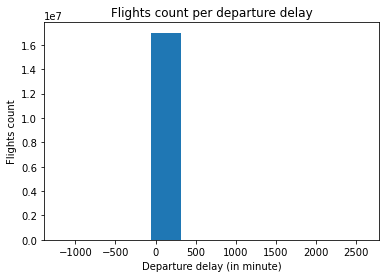

In [75]:
# Plot flights count per departure delay
plt.hist(data = clean_flight_df, x="DepDelay")

plt.xlabel("Departure delay (in minute)")
plt.ylabel("Flights count")
plt.title("Flights count per departure delay");

The above plot is really uninformative. We will review its parameters in order to make a better plot. We will draw successive plots while improving them as we go.

In [76]:
# Summary statistics of departure delay
clean_flight_df["DepDelay"].describe()

count    1.701402e+07
mean     1.124161e+01
std      3.539982e+01
min     -1.200000e+03
25%     -4.000000e+00
50%      0.000000e+00
75%      1.100000e+01
max      2.601000e+03
Name: DepDelay, dtype: float64

We will first review the bins size of the plot.

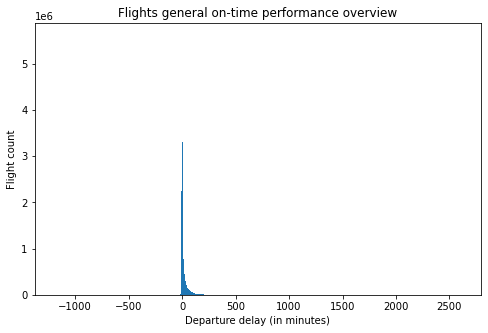

In [77]:
binsize = 5 # bin size of 5min

min_ = -1.2e3 +10
max_ = clean_flight_df["DepDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins
plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

We will zoom-in the x-axis, for a better view.

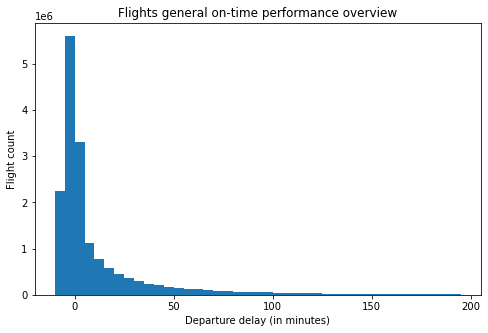

In [78]:
binsize = 5 # bin size of 5 min

min_ = -10 #-1.2e3 +100
max_ = 200 #flight_df["DepDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

The data is skewed toward the right. So we will plot the data in a log scale.

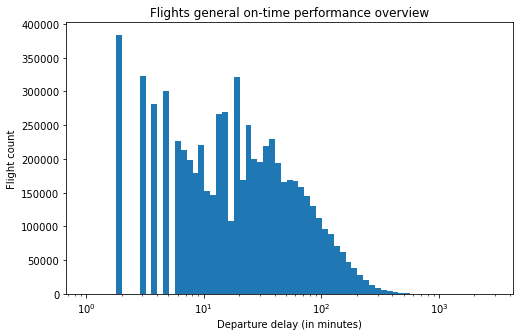

In [79]:
binsize = 0.05

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

We will make the x-ticks label more readable.

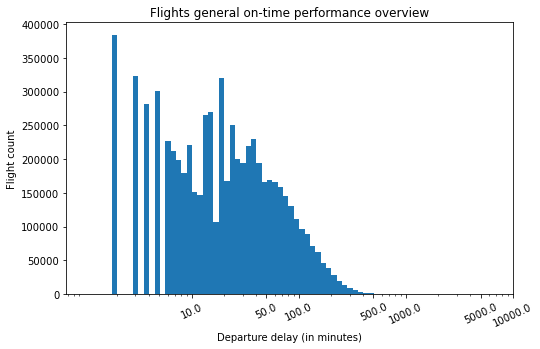

In [80]:
binsize = 0.05 

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks([10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3], [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
          rotation=25)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

Let us zoom in the relevant part of our x-axis.

In [81]:
10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3

(10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0)

<ipython-input-82-ec3b6f7cc481>:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2) # Zoom-in the x-axis


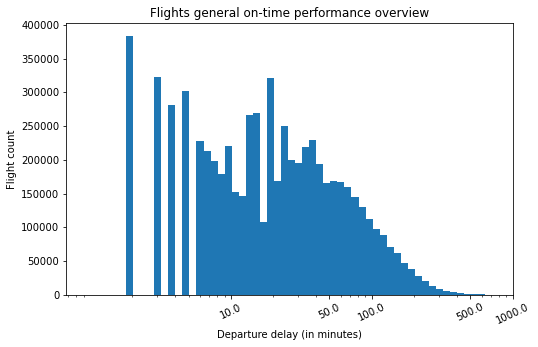

In [82]:
# Zoom-in in the x-axis

binsize = 0.05 

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks([10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3], [10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
          rotation=25)

plt.xlim(0, 10e2) # Zoom-in the x-axis

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

Now we will add more informations in the xticks labels so that we made it easier to read.

<ipython-input-83-3570149c0aae>:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2)


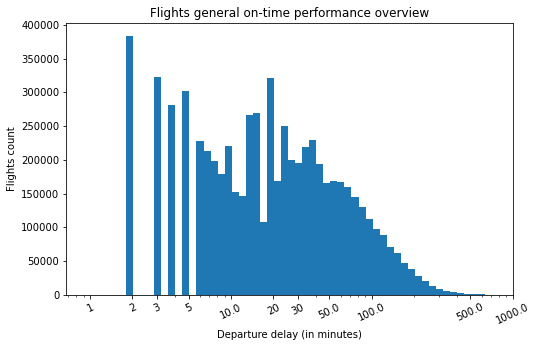

In [83]:
# Our last and perfect plot

binsize = 0.05 

min_ = 0.005 
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks([1,2,3, 10e0/2, 10e0, 20, 30, 10e1/2, 10e1,  10e2/2, 10e2,   10e3/2, 10e3], 
           [1,2,3, 5,      10.0, 20, 30, 50.0,   100.0, 500.0,  1000.0, 5000.0, 10000.0],
           rotation=25)

plt.xlim(0, 10e2)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flights count")
plt.title("Flights general on-time performance overview");

* The majority of the flights has a departure delay of 02-05 minutes, and there are a fair amount of flights which take-off 06-20 minutes after their scheduled time.
* We also have a good number of flights which departure were delayed by 30-40 minutes.
* Departure delay has a long-tailed distribution in the right side. This means there are flights which has high departure delay, although they are less in number.

The standard/usual delay seems to be between 02-40 minutes. Delays over this durations are becoming less and less the further we evolve on the right side of the chart, which shows that those delays should be related to specific reasons or special cases that we will investigate later.

<a id="arrdelay-exploration"></a>
### Investigate the arrival delay distribution

We are also going to explore how arrival delay is distributed because it is also a direct indicator of on-time perfomance.          
We are expecting to see a similarity, even if it is a small one, between its distribution and the distribution of departure delay because of ripple effect and also because once the plane has take-off, its less likely to be subject to unforeseen events that delay even more its arrival.

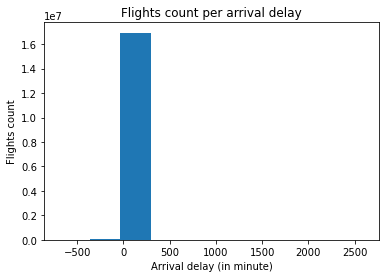

In [84]:
# Plot arrival delay distribution
plt.hist(data = clean_flight_df, x="ArrDelay")

plt.xlabel("Arrival delay (in minute)")
plt.ylabel("Flights count")
plt.title("Flights count per arrival delay");

We will improve this plot to make it more informative.

**Quick remark**: the plot look similair to the first histogram of Departure delay.

In [85]:
# Summary statistics of arrival delay vs departure delay
clean_flight_df[["ArrDelay","DepDelay"]].describe()

,ArrDelay,DepDelay
count,1.701402e+07,1.701402e+07
mean,1.044785e+01,1.124161e+01
std,3.860349e+01,3.539982e+01
min,-6.920000e+02,-1.200000e+03
25%,-9.000000e+00,-4.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.500000e+01,1.100000e+01
max,2.598000e+03,2.601000e+03


The summary statistics of arrival delay and departure delay are nearly the same. So far, everything tend to confirm that our two features are highly correlated.

Review the bins size of our previous plot.

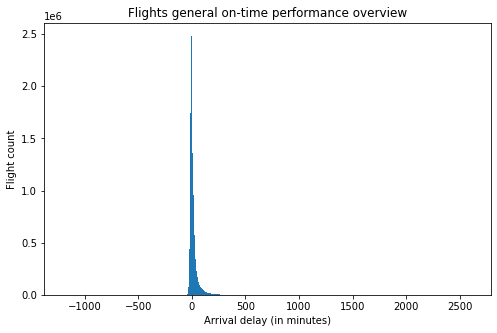

In [86]:
binsize = 5 # bin size of 5min

min_ = -1.2e3 +10
max_ = clean_flight_df["ArrDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins
plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

We will zoom-in in the x-axis for a better view of the data's distribution.

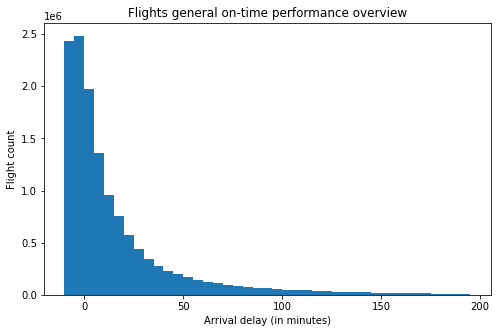

In [87]:
binsize = 5 # bin size of 5 min

min_ = -10 
max_ = 200 

bins = np.arange(min_, max_, binsize)
#bins

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights general on-time performance overview");

The slope of the arrival delay plot seem less steep than its counterpart of departure delay. Let us plot the two histograms side by side for a better comparison.

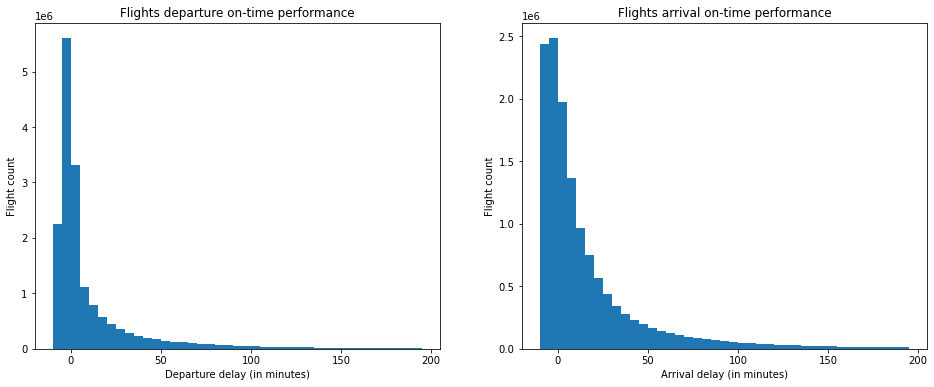

In [88]:
# Compare departure delay and arrival delay side by side

plt.figure(figsize=[16,6])

binsize = 5 # bin size of 5 min
min_ = -10 
max_ = 200
bins = np.arange(min_, max_, binsize)
#bins


# Departure delay histogram

plt.subplot(1,2,1) # plot on the left

plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights departure on-time performance");

# -------------------------

# Arrival delay histogram

plt.subplot(1,2,2) # plot on the right



plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights arrival on-time performance");

Departure delay and arrival delay appear to have a similar distribution.   
However:
* We will customize the x-ticks labels to have more fine-grained informations about the delay.               
* We are also going to set the same y-axis for the two plots, to allow comparison of the y-values on them.

Plot departure delay and arrival delay side by side

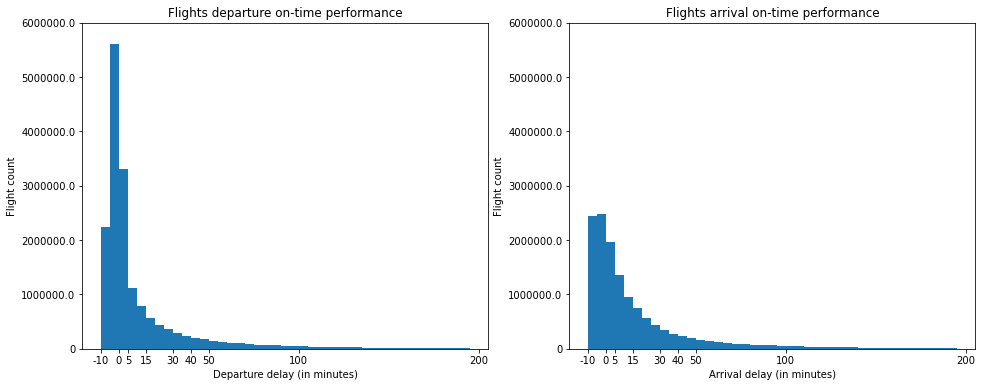

In [89]:
plt.figure(figsize=[16,6])

binsize = 5 # bin size of 5 min
min_ = -10 
max_ = 200
bins = np.arange(min_, max_, binsize)
#bins
xticks= {
    "values":[-10, 0, 5, 15, 30, 40, 50, 100, 200],
    "labels":[-10, 0, 5, 15, 30, 40, 50, 100, 200]
}

yticks= {
    "values":[0, 1e6, 2e6, 3e6, 4e6, 5e6, 6e6],
    "labels":[0, 1e6, 2e6, 3e6, 4e6, 5e6, 6e6]
}



# Departure delay histogram

plt.subplot(1,2,1) # plot on the left

plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)
plt.xticks(xticks["values"], xticks["labels"])
plt.yticks(yticks["values"], yticks["labels"])

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights departure on-time performance");

# -------------------------

# Arrival delay histogram

plt.subplot(1,2,2) # plot on the right



plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)
plt.xticks(xticks["values"], xticks["labels"])
plt.yticks(yticks["values"], yticks["labels"])

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights arrival on-time performance");

On the same scale, we notice the difference in the distribution and the difference in the bar-heights of the two plots. Since each of them is skewed toward the right, we will use the log based plots to make our conclusion about them.

Plot log scale plot for arrival delay

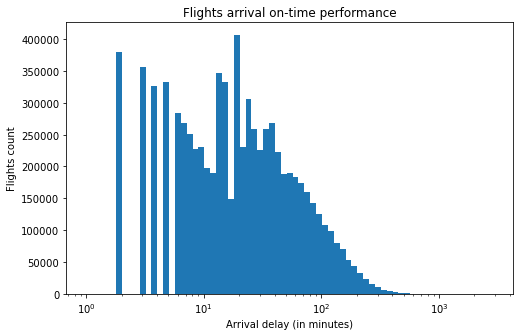

In [90]:
binsize = 0.05 

min_ = 0.005 
max_ = np.log10(clean_flight_df["ArrDelay"].max())+ binsize

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xscale("log")

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flights count")
plt.title("Flights arrival on-time performance");

We will make the xticks labels more readable.

Improve the x-ticks labels of our plot

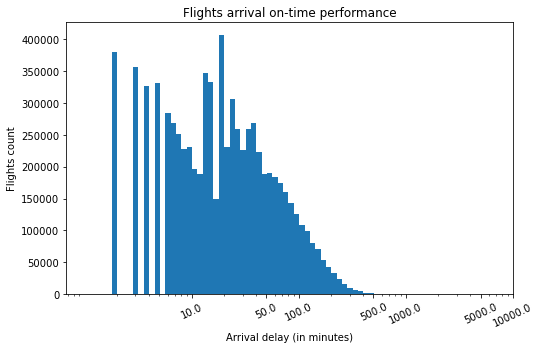

In [91]:
binsize = 0.05 

min_ = 0.005 #-1.2e3 +100
max_ = np.log10(clean_flight_df["ArrDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xscale("log")

xticks= {
    "values":[10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3],
    "labels":[10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0]
}

plt.xticks(xticks["values"], xticks["labels"],rotation=25)

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flights count")
plt.title("Flights arrival on-time performance");

We are going to zoom-in in the relevant part of the x-axis

Zoom-in on the x-axis

<ipython-input-92-b3fe37f4d5d1>:21: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2) # Zoom-in the x-axis


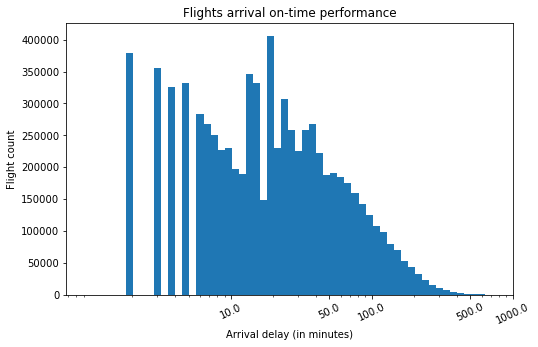

In [92]:
binsize = 0.05 

min_ = 0.005 
max_ = np.log10(clean_flight_df["ArrDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xscale("log")

xticks= {
    "values":[10e0,10e1/2, 10e1, 10e2/2, 10e2, 10e3/2, 10e3],
    "labels":[10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0]
}

plt.xticks(xticks["values"], xticks["labels"],rotation=25)


plt.xlim(0, 10e2) # Zoom-in the x-axis

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights arrival on-time performance");

We will review the xticks labels to make the plot easier to read

Improve the labels on the x-axis

<ipython-input-93-f8233664ac39>:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2)


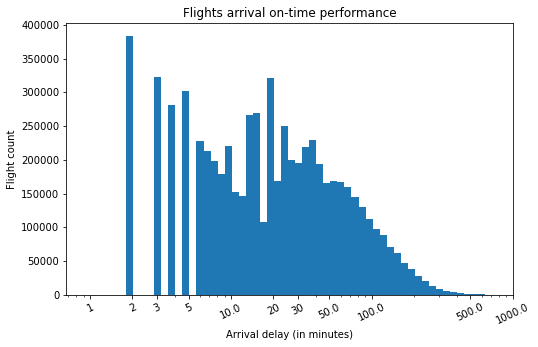

In [93]:
binsize = 0.05 

min_ = 0.005 
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize # np.log10(200) # #200  

bins = 10**np.arange(min_, max_, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

xticks= {
    "values":[1,2,3, 10e0/2, 10e0, 20, 30, 10e1/2, 10e1,  10e2/2, 10e2,   10e3/2, 10e3],
    "labels":[1,2,3, 5,      10.0, 20, 30, 50.0,   100.0, 500.0,  1000.0, 5000.0, 10000.0]
}

plt.xticks(xticks["values"], xticks["labels"],rotation=25)

plt.xlim(0, 10e2)

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flight count")
plt.title("Flights arrival on-time performance");

Planes always has arrival delay, of at least nearly 02 minutes. This delay is acceptable since the weather (wind power/speed/direction, rain level, ...) cannot be predicted 100% accurate.            
Arrival delay mostly fall in the range of 02-40 minutes. The flights arriving after 40 minutes are less and less.

Now we will put the final departure delay plot and the final arrival delay plot side by side to compare them.

<ipython-input-94-b0bf4852936d>:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2)
<ipython-input-94-b0bf4852936d>:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 10e2)


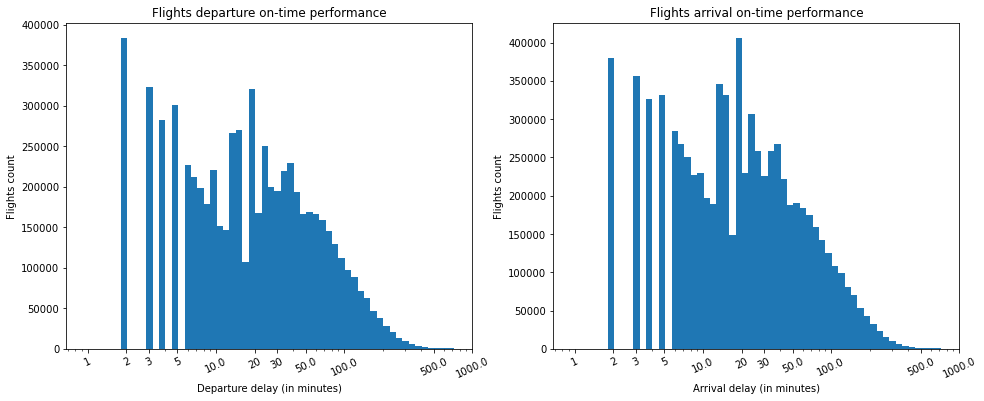

In [94]:
# Compare departure delay and arrival delay side by side

plt.figure(figsize=[16,6])

binsize = 0.05 
min_ = 0.005 
max_ = np.log10(clean_flight_df["DepDelay"].max())+ binsize   
bins = 10**np.arange(min_, max_, binsize)
#bins
xticks= {
    "values":[1,2,3, 10e0/2, 10e0, 20, 30, 10e1/2, 10e1,  10e2/2, 10e2,   10e3/2, 10e3],
    "labels":[1,2,3, 5,      10.0, 20, 30, 50.0,   100.0, 500.0,  1000.0, 5000.0, 10000.0]
}

# yticks= {
#     "values":[0, 1e6, 2e6, 3e6, 4e6, 5e6, 6e6],
#     "labels":[0, 1e6, 2e6, 3e6, 4e6, 5e6, 6e6]
# }




#--------------------------





# Departure delay histogram

plt.subplot(1,2,1) # plot on the left
plt.hist(data=clean_flight_df, x="DepDelay", bins=bins)

plt.xscale("log")

plt.xticks(xticks["values"], xticks["labels"],rotation=25)

plt.xlim(0, 10e2)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Flights count")
plt.title("Flights departure on-time performance");

#-------------------------------

# Arrival delay histogram

plt.subplot(1,2,2) # plot on the right
plt.hist(data=clean_flight_df, x="ArrDelay", bins=bins)

plt.xscale("log")

plt.xticks(xticks["values"], xticks["labels"],rotation=25)

plt.xlim(0, 10e2)

plt.xlabel("Arrival delay (in minutes)")
plt.ylabel("Flights count")
plt.title("Flights arrival on-time performance");

Departure delay distribution, and arrival delay distribution are nearly the same. The small difference may can from the fact that a plane taking off at a given time may arrive after its scheduled arrival time, as we saw before. This will put the plane in the next temporal's bin, which is what we are seeing by the difference of the ups-and-downs of the bars between the two histograms.

<br/><br/>

💡 *We will put the above plot in our explanatory analysis. We will review its comments, to make it more appealing for a public*

<a id="securitydelay-exploration"></a>
### Investigate the security delay distribution

Security check is an important and critical factor in an airport. So we will explore how delays related to it is distributed.

In [95]:
# Summary statistics of security delay
clean_flight_df["SecurityDelay"].describe()

count    1.701402e+07
mean     2.760113e-02
std      1.193262e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.920000e+02
Name: SecurityDelay, dtype: float64

The mean security delay is 0.03 minute. This mean that security checks doesn't bring so much delay. Since the mean delay is 0.03 minute, the maximum delay of 392 should be an outlier, or even an entry error.

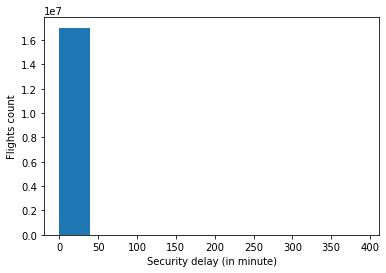

In [96]:
# Plot security delay histogram
plt.hist(data = clean_flight_df, x="SecurityDelay")

plt.xlabel("Security delay (in minute)")
plt.ylabel("Flights count");

Security delay range from 0 minute to a value less than 50 minutes. We will improve the plot to read more information from it.

Review the binsize of the plot

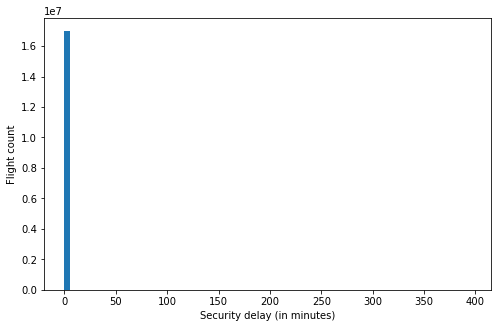

In [97]:
binsize = 5 # bin size of 5min

min_ = 0
max_ = clean_flight_df["SecurityDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins
plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="SecurityDelay", bins=bins)

plt.xlabel("Security delay (in minutes)")
plt.ylabel("Flight count");

We will zoom-in in the x-axis

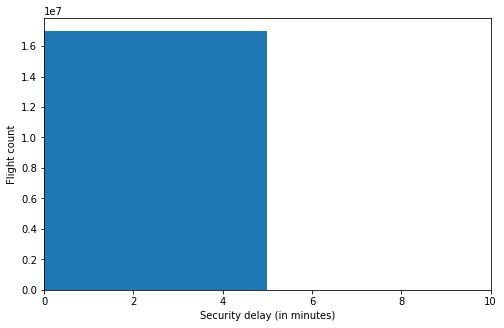

In [98]:
# Zoom-in in x-axis

binsize = 5 # bin size of 5min

min_ = 0
max_ = clean_flight_df["SecurityDelay"].max() + binsize

bins = np.arange(min_, max_, binsize)
#bins
plt.figure(figsize=[8,5])
plt.hist(data=clean_flight_df, x="SecurityDelay", bins=bins)

plt.xlim(0,10)

plt.xlabel("Security delay (in minutes)")
plt.ylabel("Flight count");

Security delay fall in the range of 00 to 05 minutes. This should not have high impact on departure delay.

<a id="general-bivariate-exploration"></a>
### General bivariate exploration
Now the prelude to the main work: we are going to understand the pairwise correlations between features in the data. We will mainly be interested in the features that has high correlation with departure delay and with arrival delay. Others lines of investigations may reveal themselves as we go.

In [99]:
# Recall the structure of clean_flight_df
clean_flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17014015 entries, 0 to 17014014
Data columns (total 39 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            object 
 5   CRSDepTime         object 
 6   ArrTime            object 
 7   CRSArrTime         object 
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       float64
 24  WeatherDelay       float64
 25  NASDelay        

In [100]:
# Making sure there is no null value
clean_flight_df.isna().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
OtherDelay           0
PlaneType            0
PlaneManufacturer    0
PlaneIssueDate       0
PlaneModel           0
PlaneStatus          0
AircraftType         0
PlaneEngine          0
PlaneCreationYear    0
PlaneAge             0
UniqueCarrierDesc    0
dtype: int64

In [101]:
# Record the variables of interest 
numeric_variables = ["Year","Month","DayofMonth","DayOfWeek","ArrDelay","DepDelay","Distance","TaxiIn","TaxiOut",
                    "CarrierDelay","WeatherDelay","NASDelay", "SecurityDelay","LateAircraftDelay","PlaneCreationYear",
                    "PlaneAge"]
categorical_variables = ["TailNum","Origin","Dest","PlaneType","PlaneManufacturer","PlaneModel","UniqueCarrierDesc",
                         "PlaneStatus","AircraftType","PlaneEngine"]

We are going to explore the correlation between our numerical features.

In [102]:
# Correlation between numerical features
clean_flight_df[numeric_variables].corr()

,Year,Month,DayofMonth,DayOfWeek,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,PlaneCreationYear,PlaneAge
Year,1.000000,-0.070446,-0.003141,-0.002829,0.102158,0.095445,-0.002601,-0.016417,0.045606,0.048608,0.017359,0.051756,0.004824,0.078442,0.006837,-0.006837
Month,-0.070446,1.000000,0.012174,0.009286,-0.037654,-0.032468,0.000125,-0.002559,-0.002681,-0.016920,-0.011101,-0.021307,-0.002241,-0.024692,-0.001046,0.001046
DayofMonth,-0.003141,0.012174,1.000000,-0.010347,0.014777,0.014725,0.000735,0.000540,0.003722,0.006170,0.002611,0.004710,0.001207,0.011535,-0.000445,0.000445
DayOfWeek,-0.002829,0.009286,-0.010347,1.000000,-0.005302,0.004350,0.012952,0.000697,-0.021367,0.009501,-0.001456,-0.015817,0.003557,-0.001671,0.000067,-0.000067
ArrDelay,0.102158,-0.037654,0.014777,-0.005302,1.000000,0.922881,-0.006953,0.056777,0.330635,0.557557,0.277934,0.508488,0.032448,0.603634,0.001344,-0.001344
DepDelay,0.095445,-0.032468,0.014725,0.004350,0.922881,1.000000,0.006520,0.044348,0.096911,0.592705,0.273757,0.333650,0.032608,0.638619,0.003472,-0.003472
Distance,-0.002601,0.000125,0.000735,0.012952,-0.006953,0.006520,1.000000,0.005231,0.111657,0.007554,-0.012648,0.025471,0.004015,-0.009647,0.029690,-0.029690
TaxiIn,-0.016417,-0.002559,0.000540,0.000697,0.056777,0.044348,0.005231,1.000000,0.009017,0.023059,0.073195,0.040364,0.001731,0.005823,0.002326,-0.002326
TaxiOut,0.045606,-0.002681,0.003722,-0.021367,0.330635,0.096911,0.111657,0.009017,1.000000,0.045433,0.077256,0.470991,0.006834,0.060558,0.009163,-0.009163
CarrierDelay,0.048608,-0.016920,0.006170,0.009501,0.557557,0.592705,0.007554,0.023059,0.045433,1.000000,-0.010377,0.012094,-0.003675,0.017351,-0.001386,0.001386


We will use a heatmap to make interesting correlations easier to locate.

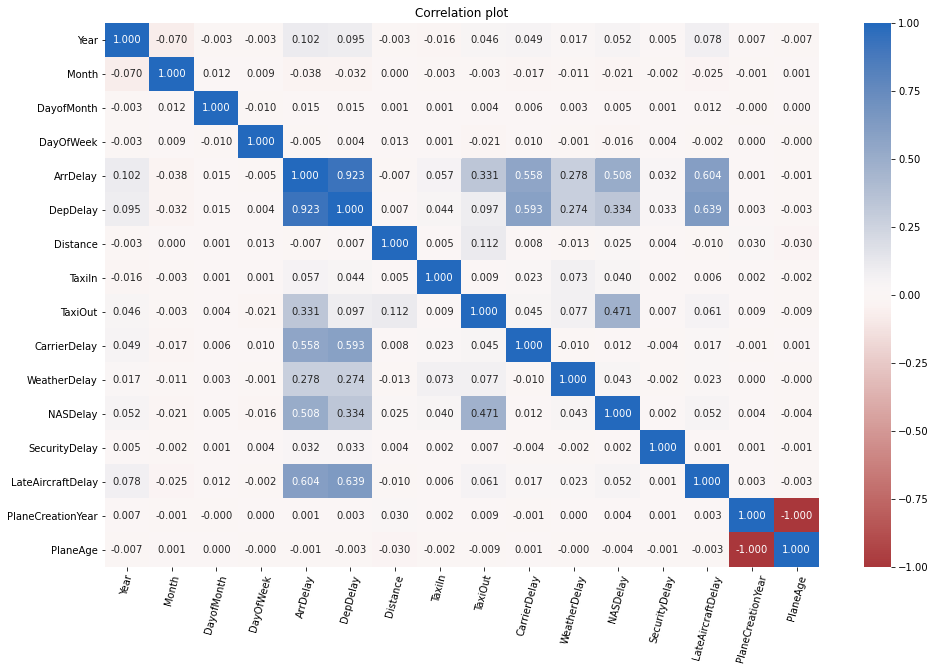

In [103]:
# Correlation plot
plt.figure(figsize = [16, 10])
sb.heatmap(clean_flight_df[numeric_variables].corr(), annot = True, fmt = ".3f", cmap = "vlag_r", center = 0)
#plt.show()

plt.title("Correlation plot")

plt.xticks(rotation=75);

Looking at the heatmap, we have some interesting relationships between many features. One thing to take note of is the high correlation between `ArrDelay` and `DepDelay`, nearly 1. This means that:
* An increase in the departure delay has a high chance to induce an increase in the arrival delay, and vice versa. This confirm the relationship we speculated between the two.
* In order to understand on-time performance of the planes, we can center our analyzes around only one of those two features, since they increase-decrease together.

The delay reasons (NAS, Security, Late Aircraft, Weather) don't impact each other; but `CarrierDelay` and `LateAircraftDelay` have high impact on departure delay and arrival delay while `WeatherDelay` and `NASDelay` have low impact on them. `SecurityDelay` has no impact on them.

We will also take note of the fact that `DepDelay` and `PlaneAge` are not correlated, meaning the departure delay of a plane is not related to its age.

We will use a plot matrice to complement what the above heatmap is telling us. We will sample 600 observations so that the plots are clearer and render faster

In [104]:
# Sample 600 observations

random_state_seed = 5 # set seed for reproducibility
clean_flight_samples = clean_flight_df.sample(n=600, random_state=random_state_seed)
clean_flight_samples.head(3).T

,3763147,1118444,7418233
Year,2007,2007,2005
Month,6,2,6
DayofMonth,19,27,3
DayOfWeek,2,2,5
DepTime,739,839,533
CRSDepTime,740,845,535
ArrTime,1004,1016,753
CRSArrTime,1025,1013,805
UniqueCarrier,WN,UA,OH
FlightNum,2264,817,4957


In [105]:
# numeric_variables

In [106]:
# #plt.figure(figsize=[50,40])

# g = sb.PairGrid(data = clean_flight_samples, vars = numeric_variables)
# g = g.map_diag(plt.hist, bins = 20)
# g.map_offdiag(plt.scatter)

# plt.title("PairGrid plot");

<!-- The plot is too small to gain insights. Although we can somewhat see correlation, it is impossible to see concerned variables. So we will not be able to use our matrice plot. -->

<a id="depdelay-vs-arrdelay"></a>
### Does departure delay imperatively imply arrival delay ?

The heatmap we saw before is telling us "yes, it is". But we still want to observe this correlation in more details before discarding arrival delay to focus on departure delay.

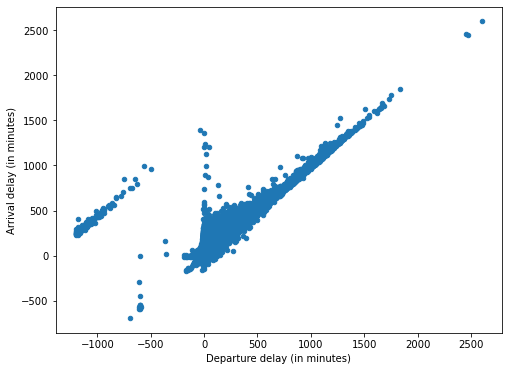

In [107]:
clean_flight_df.plot(kind="scatter",x="DepDelay",y="ArrDelay", figsize=(8,6))

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Arrival delay (in minutes)");

The plot confirm the linear relationship between the two variable : a high departure delay means a high arrival delay.                 
Let's improve our plot to see if we can gain more insights.

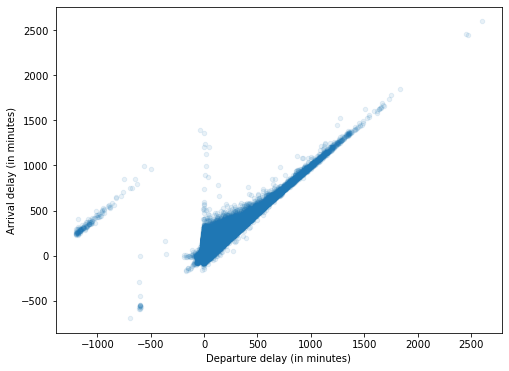

In [108]:
# Set transparency to the points in the plot
clean_flight_df.plot(kind="scatter",x="DepDelay",y="ArrDelay", figsize=(8,6), alpha=1/10)

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Arrival delay (in minutes)");

Looking at the places where we have high concentration of data, we can see that the departure delay is always roughly equal to the arrival delay. So we can conclude that the flight's duration doesn't differ much from what was scheduled, whatever the departure time is.           

<a id="rippleeffect-vs-depdelay"></a>
### Investigate the ripple effect on departure delay

Our goal is to observe how the ripple effect impact the departure delay of a flight.

In [109]:
# sb.regplot(data= clean_flight_df, x="LateAircraftDelay", y="DepDelay") #plt.scatter

# plt.xlabel("Ripple effect (in minutes)")
# plt.ylabel("Departure delay (in minutes)")

# plt.title("Ripple effect impact on departure delay");

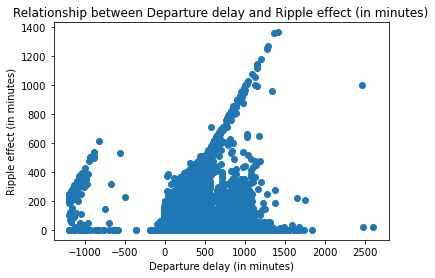

In [110]:
plt.scatter(data= clean_flight_df, x="DepDelay", y="LateAircraftDelay") 

plt.xlabel("Departure delay (in minutes)")
plt.ylabel("Ripple effect (in minutes)")

plt.title("Relationship between Departure delay and Ripple effect (in minutes)");

Departure delay is indeed a factor that causes ripple effect : a plane which is late on its departure at the previous airport is very likely to also be late on the departure delay of its next airport.

<a id="nasdelay-vs-depdelay"></a>
### Investigate how NAS delay impact departure delay

We will explore how delay related to NAS are correlated to the departure delay of a flight.

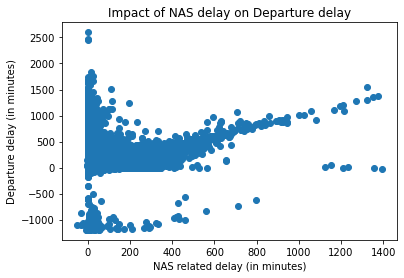

In [111]:
plt.scatter(data= clean_flight_df, x="NASDelay", y="DepDelay") 

plt.xlabel("NAS related delay (in minutes)")
plt.ylabel("Departure delay (in minutes)")

plt.title("Impact of NAS delay on Departure delay");

We have a small correlation between `NASDelay` and `DepDelay`. This means that a given NAS Delay (in minutes) will cause a small departure delay.

<a id="carrierdelay-vs-depdelay"></a>
### Investigate carrier delay impact on departure delay


We will observe how delays related to the carrier can impact departure time.

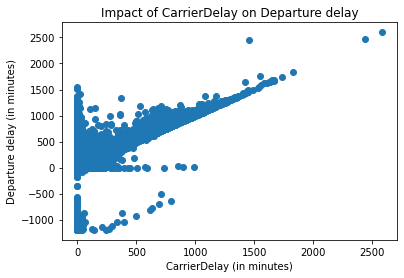

In [112]:
plt.scatter(data= clean_flight_df, x="CarrierDelay", y="DepDelay") 

plt.xlabel("CarrierDelay (in minutes)")
plt.ylabel("Departure delay (in minutes)")

plt.title("Impact of CarrierDelay on Departure delay");

The correlation between the two features is fairly high. An increase in CarrierDelay result in a great delay of departure time; so optimizing carrier operations in order to reduce CarrierDelay will help flights taking-off on time.

<div id="weatherdelay-vs-depdelay"></div>

### Investigate how weather delay impact departure delay


We will investigate how delays caused by extreme or hazardous weather conditions impact delay related to arrival/departure. Since departure and arrival delays are highly correlated, we will analyze the relationship between `DepDelay` and `WeatherDelay`, while keeping in mind it would be the same between `ArrDelay` and `WeatherDelay`.

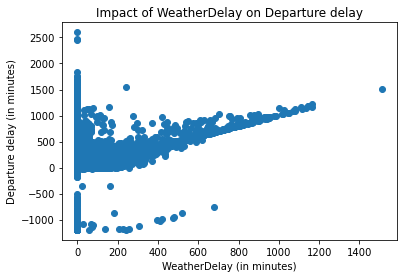

In [113]:
plt.scatter(data= clean_flight_df, x="WeatherDelay", y="DepDelay") 

plt.xlabel("WeatherDelay (in minutes)")
plt.ylabel("Departure delay (in minutes)")

plt.title("Impact of WeatherDelay on Departure delay");

This plot suggests that a delay related to weather lead to a delay in departure.

<a id="securitydelay-vs-depdelay"></a>
### Investigate the Security delay effect on departure delay

We will explore the relationship between `SecurityDelay` and `DepDelay`.

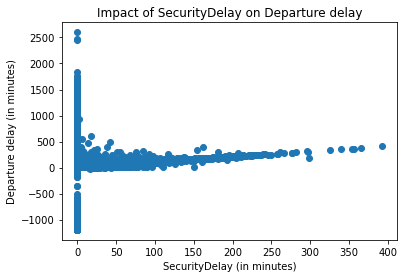

In [114]:
# Scatter plot SecurityDelay vs DepDelay
plt.scatter(data= clean_flight_df, x="SecurityDelay", y="DepDelay") 

plt.xlabel("SecurityDelay (in minutes)")
plt.ylabel("Departure delay (in minutes)")

plt.title("Impact of SecurityDelay on Departure delay");

The correlation between the two variables is weak, as we saw before. Security delays have a negligible impact on departure delay.

Let's zoom-in in the x-axis to have a better view of how data is distributed

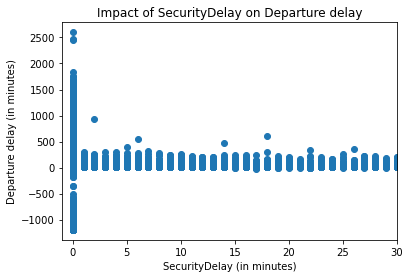

In [115]:
plt.scatter(data= clean_flight_df, x="SecurityDelay", y="DepDelay") 

plt.xlim(-1,30)

plt.xlabel("SecurityDelay (in minutes)")
plt.ylabel("Departure delay (in minutes)")

plt.title("Impact of SecurityDelay on Departure delay");

Security delay has really little to none impact on departure delay

<a id="categorical-features-exploration"></a>
### Categorical features exploration

We are going to explore the categorical features content in order to get an idea of how to explore a relationship between each of them and departure delay.

In [116]:
categorical_variables

['TailNum',
 'Origin',
 'Dest',
 'PlaneType',
 'PlaneManufacturer',
 'PlaneModel',
 'UniqueCarrierDesc',
 'PlaneStatus',
 'AircraftType',
 'PlaneEngine']

In [117]:
plot_matrice_xvars = [] # will contain features to be used on the x-axis of our future plot-matrice

<a id="tailnum-exploration"></a>
**Exploring `TailNum` feature**

In [118]:
# Number of unique occurence
clean_flight_df["TailNum"].nunique()

4329

In [119]:
# What does a plane tail number look like
clean_flight_df["TailNum"].unique()

array(['N935UA', 'N941UA', 'N342UA', ..., 'N836AL', 'N841AL', 'N843AL'],
      dtype=object)

In [120]:
# Occurence count for each unique value
flights_per_plane_count = clean_flight_df["TailNum"].value_counts()
flights_per_plane_count

N308SW    14070
N478HA    11922
N480HA    11832
N479HA    11711
N485HA    11661
          ...  
N713TW        3
N855NW        3
N77019        2
N853NW        1
N857NW        1
Name: TailNum, Length: 4329, dtype: int64

There are planes which didn't flight that much in the time frame of our analysis. 
For our in-depth analysis in this feature, we will not include the planes with small number of flight since their data may not be representative of the reality of other flights.

In [121]:
flights_per_plane_count.describe()

count     4329.000000
mean      3930.241395
std       1962.549936
min          1.000000
25%       2482.000000
50%       4026.000000
75%       5218.000000
max      14070.000000
Name: TailNum, dtype: float64

Looking at the 25% quantile, we will consider 2482 the minimum number of flights a plane should made in order to be considered in our in-depth analysis.

Let's look at the flights count per plane on a plot.

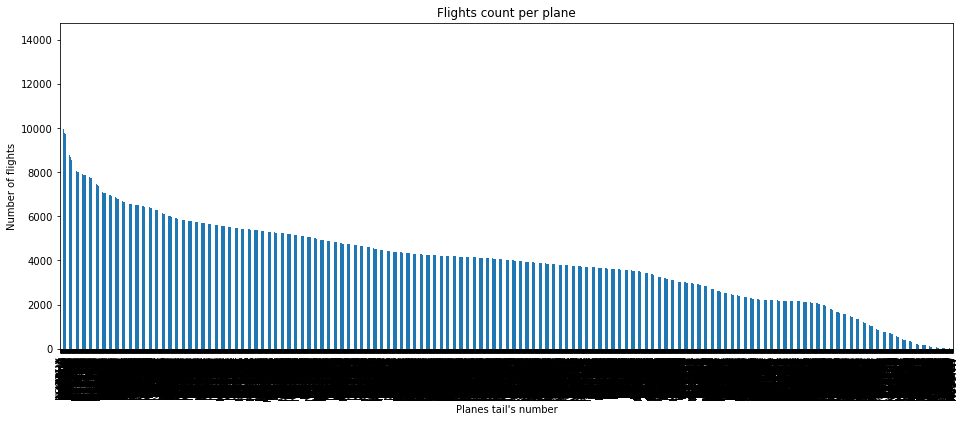

In [122]:
flights_per_plane_count.plot(kind="bar", figsize=(16,6))

plt.xlabel("Planes tail's number")
plt.ylabel("Number of flights")
plt.title("Flights count per plane");

Although the x-axis doesn't give us any information regarding the plane tail number, we can still observe the neat decrease of the flights count. This tell us there are planes with much more activity than others.


<!-- An interesting question would be "Is there a relationship between a plane number of flights and its on-time performance ?".          
This we will make us explore the following leads :
* on-time performance per plane (we will sample 1000 planes having the more flights, and 1000 planes having the less flights; recall that a plane should have a least 2482 flights to be included in our selection)
* on-time performance per freight company

We will include a third variable in each of our analysis: the city. This is to include the fact that the number of people in a city has impact on the number of flights a plane may have done. -->


**Exploring `Origin` feature**

In [123]:
# Number of origin aiports in our dataset
clean_flight_df["Origin"].nunique()

304

In [124]:
# Count of each origin aiports in our dataset
flights_per_origin_count = clean_flight_df["Origin"].value_counts()
flights_per_origin_count

ATL    1121878
ORD     931786
DEN     620532
IAH     605637
DFW     595891
        ...   
MKG         14
OGD          1
PLN          1
CKB          1
CYS          1
Name: Origin, Length: 304, dtype: int64

We have origin airports with little departure count and origin airports with high number of departure. We will discard the origin airports with small number of departure for any in-depth analysis, since they may be outliers.

In [125]:
flights_per_origin_count.describe()

count    3.040000e+02
mean     5.596715e+04
std      1.284854e+05
min      1.000000e+00
25%      2.828000e+03
50%      1.038000e+04
75%      4.233150e+04
max      1.121878e+06
Name: Origin, dtype: float64

In [126]:
2.82e3

2820.0

2820, the number of flight that at least 25% our origin airports has recorded, will be considered as the treshold of flights count an airport should have in order to be included in any in-depth analysis.

**Exploring `Dest` feature**

In [127]:
# Number of destination aiports in our dataset
clean_flight_df["Dest"].nunique()

301

In [128]:
# Count of each destination aiports in our dataset
destinations_count = clean_flight_df["Dest"].value_counts()
destinations_count

ATL    1110696
ORD     926024
DEN     617278
IAH     601981
DFW     592113
        ...   
ADK         86
MKG         18
GCC         16
RKS          8
PLN          1
Name: Dest, Length: 301, dtype: int64

**Exploring `PlaneType` feature**

In [129]:
# Number of plane types in our dataset
clean_flight_df["PlaneType"].nunique()

5

In [130]:
# Count planes per type
planes_per_type_count = clean_flight_df["PlaneType"].value_counts()
planes_per_type_count

Corporation            16884195
Individual                63857
Foreign Corporation       48843
Co-Owner                  12975
Partnership                4145
Name: PlaneType, dtype: int64

We will plot the count of planes per type

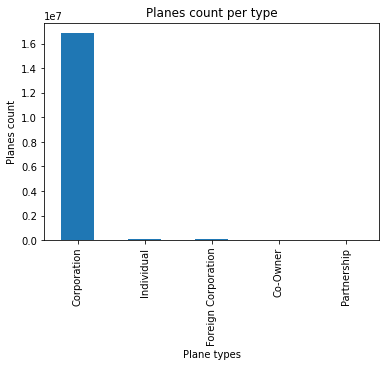

In [131]:
planes_per_type_count.plot(kind="bar")

plt.xlabel("Plane types")
plt.ylabel("Planes count")
plt.title("Planes count per type");

Nearly all our planes are of type (national) Corporation. Other plane types are not represented as much as this one.

**Exploring `PlaneManufacturer` feature**

In [132]:
# Number of unique values
clean_flight_df["PlaneManufacturer"].nunique()

33

In [133]:
# Occurence count for each value
clean_flight_df["PlaneManufacturer"].value_counts()

BOEING                            6457451
EMBRAER                           3103991
BOMBARDIER INC                    2620859
AIRBUS INDUSTRIE                  1561184
MCDONNELL DOUGLAS                 1061311
AIRBUS                             771277
MCDONNELL DOUGLAS AIRCRAFT CO      545205
CANADAIR                           443238
DOUGLAS                            146737
MCDONNELL DOUGLAS CORPORATION       76844
DEHAVILLAND                         69821
CESSNA                              40048
AEROSPATIALE/ALENIA                 25273
PIPER                               19348
BEECH                               12461
SAAB-SCANIA                          9422
RAVEN                                8207
BELL                                 4311
WOBIG WAYNE R                        4290
HELIO                                4241
LEBLANC GLENN T                      4220
FRIEDEMANN JON                       4204
STINNETT RON                         4196
MARZ BARRY                        

**Exploring `PlaneModel` feature**

In [134]:
# Number of unique values
clean_flight_df["PlaneModel"].nunique()

160

In [135]:
# Occurence count for each value
clean_flight_df["PlaneModel"].value_counts()

CL-600-2B19    2155763
EMB-145LR      1277618
A320-232        885495
737-3H4         843259
CL-600-2C10     722802
                ...   
747-451             44
DHC-8-102           43
A330-223            15
EXEC 162F           10
777-232LR            4
Name: PlaneModel, Length: 160, dtype: int64

**Exploring `UniqueCarrierDesc` feature**

In [136]:
# Number of unique values
clean_flight_df["UniqueCarrierDesc"].nunique()

21

In [137]:
# Occurence count for each value
clean_flight_df["UniqueCarrierDesc"].value_counts()

Southwest Airlines Co.                                                                 1888632
Skywest Airlines Inc.                                                                  1592494
United Air Lines Inc.                                                                  1464925
Delta Air Lines Inc.                                                                   1451901
American Eagle Airlines Inc.                                                           1368086
Expressjet Airlines Inc.                                                               1254164
Northwest Airlines Inc.                                                                1127597
US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)     949758
American Airlines Inc.                                                                  924178
Continental Air Lines Inc.                                                              908011
Atlantic Southeast Airlines                       

**Exploring `PlaneStatus` feature**

In [138]:
# Number of unique value
clean_flight_df["PlaneStatus"].nunique()

2

In [139]:
# Occurence count for each value
clean_flight_df["PlaneStatus"].value_counts()

Valid                17013128
Registered to Mfr         887
Name: PlaneStatus, dtype: int64

**Exploring `AircraftType` feature**

In [140]:
# Number of unique value
clean_flight_df["AircraftType"].nunique()

4

In [141]:
# Occurence count for each value
clean_flight_df["AircraftType"].value_counts()

Fixed Wing Multi-Engine     16921598
Fixed Wing Single-Engine       78185
Balloon                         8207
Rotorcraft                      6025
Name: AircraftType, dtype: int64

**Exploring `PlaneEngine` feature**

In [142]:
# Number of unique value
clean_flight_df["PlaneEngine"].nunique()

7

In [143]:
# Occurence count for each value
clean_flight_df["PlaneEngine"].value_counts()

Turbo-Fan        10922728
Turbo-Jet         5335202
Turbo-Prop         649163
Reciprocating       82446
4 Cycle             10254
None                 8207
Turbo-Shaft          6015
Name: PlaneEngine, dtype: int64

<a id="categorical-vs-numerical"></a>
### Categorical features vs numerical features

We are going to use a plot matrix to see if we can gain some lead for further and more detailed explorations.


In [144]:
# Recall the structure of our samples
clean_flight_samples.shape

(600, 39)

In [145]:
categorical_variables

['TailNum',
 'Origin',
 'Dest',
 'PlaneType',
 'PlaneManufacturer',
 'PlaneModel',
 'UniqueCarrierDesc',
 'PlaneStatus',
 'AircraftType',
 'PlaneEngine']

We will make a plot of our variables of interest.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


<Figure size 720x1440 with 0 Axes>

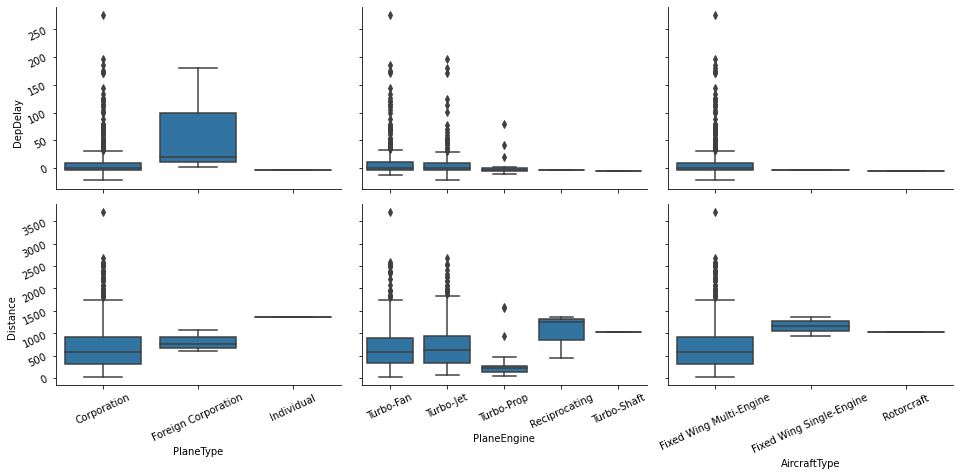

In [146]:
cat_vars = ["PlaneType","PlaneEngine","AircraftType"] # PlaneStatus
num_vars = ["DepDelay","Distance"]

plot_matrice(df=clean_flight_samples, x_vars=cat_vars, y_vars = num_vars)

* Regarding `PlaneType`:
    * (National) Corporation plane types tend to make less distance than foreign corporation. This sould be related to the fact there are many national flights going to nearby states or cities instead of going to other continents. And Individual flights tend to make higher distance than national and foreign corporation; this should be business-men private flights roaming the world for their work.
    * **Foreign corporations have higher departure delay than (national) Corporation.**. And Indivual flights tend to have no departure delay; once again, this should be related to the fact that those flights are private one related to business-men.
* Regarding `PlaneEngine`:
    * The planes have approximatively the same departure delay; however, `Turbo-Fan` and `Turbo-jet` have a little higher departure delay compared to other plane engines.
    * Planes with `Reciprocating` engine are doing a higher distance compared to the other engine types. `Turbo-Fan` and `Turbo-Jet` are equal in term of flight distance, while `Turbo-Prop` is doing really small distances.
    
* Regarding `AircraftType`:
    * Planes with `Fixed Wing Multi-Engine` departure delays is are a little bit higher than other types of aircraft. This type of planes are also doing a smaller distance than others.
    
  
We will confirm our finding here by investigating the relationship between:
* `PlaneType` and `DepDelay`
* `AircraftType` and `DepDelay`

In [147]:
# cat_vars = ["PlaneType","PlaneStatus","PlaneEngine","AircraftType"]

# def boxgrid(x, y, **kwargs):
#     """ Quick hack for creating box plots with seaborn's PairGrid. """
#     default_color = sb.color_palette()[0]
#     sb.boxplot(x=x, y=y, color=default_color)

# plt.figure(figsize = [10, 20])
# g = sb.PairGrid(data = clean_flight_samples, y_vars = ["DepDelay","Distance"], x_vars = cat_vars,
#                 size = 3, aspect = 1.5)
# g.map(boxgrid)


# for ax in g.axes.flatten():
#     # rotate x axis labels
#     #ax.set_xlabel(ax.get_xlabel(), rotation = 90)
#     ax.tick_params(rotation=25)
    
#     # rotate y axis labels
#     # ax.set_ylabel(ax.get_ylabel(), rotation = 0)
#     # set y labels alignment
    
#     ax.yaxis.get_label().set_horizontalalignment('right')


# plt.show();

<a id="tailnum-vs-depdelay"></a>
### Explore relationship between planes and departure delays

We are going to explore on-time performance per plane.             
For our study, we will sample 1000 planes having the more flights, and 1000 planes having the less flights; recall that a plane should have a least 2482 flights to be included in our selection.
[Read more...](#tailnum-exploration)

We will first convert our flights count serie to dataframe, for easier manipulation

In [148]:
# Convert the serie of flights count per plane to dataframe
count_flights_per_plane_df = flights_per_plane_count.rename_axis('TailNum').reset_index(name='FlightCounts')
count_flights_per_plane_df

,TailNum,FlightCounts
0,N308SW,14070
1,N478HA,11922
2,N480HA,11832
3,N479HA,11711
4,N485HA,11661
...,...,...
4324,N713TW,3
4325,N855NW,3
4326,N77019,2
4327,N853NW,1


Now we are going to select the planes with at least 2482 flights record

In [149]:
# Select the planes with the minimum of flights count threshold
threshold_count = 2482

planes_respecting_threshold = count_flights_per_plane_df[ count_flights_per_plane_df["FlightCounts"] >= threshold_count ]
planes_respecting_threshold

,TailNum,FlightCounts
0,N308SW,14070
1,N478HA,11922
2,N480HA,11832
3,N479HA,11711
4,N485HA,11661
...,...,...
3242,N17719,2487
3243,N641AA,2485
3244,N37293,2484
3245,N249JB,2482


Now we will define our sample of planes : 1000 planes with the greater number of flights, and 1000 planes with the less number of flights

In [150]:
# Planes with greater number of flights
top_planes = planes_respecting_threshold.iloc[:1000,:]
print(top_planes.shape)
print(top_planes.head())
print(top_planes.tail())

# Planes with lesser number of flights
bottom_planes = planes_respecting_threshold.iloc[-1000:,:]
print(bottom_planes.shape)
print(bottom_planes.head())
print(bottom_planes.tail())

(1000, 2)
  TailNum  FlightCounts
0  N308SW         14070
1  N478HA         11922
2  N480HA         11832
3  N479HA         11711
4  N485HA         11661
    TailNum  FlightCounts
995  N751UW          5328
996  N12563          5328
997  N16954          5327
998  N496CA          5327
999  N13964          5325
(1000, 2)
     TailNum  FlightCounts
2247  N16650          3940
2248  N563AA          3940
2249  N276AT          3940
2250  N75410          3940
2251  N23661          3937
     TailNum  FlightCounts
3242  N17719          2487
3243  N641AA          2485
3244  N37293          2484
3245  N249JB          2482
3246  N632AA          2482


In [151]:
# Merge the sampled planes in one dataframe
sample_planes_df = pd.concat([top_planes, bottom_planes])
sample_planes_df

,TailNum,FlightCounts
0,N308SW,14070
1,N478HA,11922
2,N480HA,11832
3,N479HA,11711
4,N485HA,11661
...,...,...
3242,N17719,2487
3243,N641AA,2485
3244,N37293,2484
3245,N249JB,2482


In [152]:
sample_planes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 3246
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TailNum       2000 non-null   object
 1   FlightCounts  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


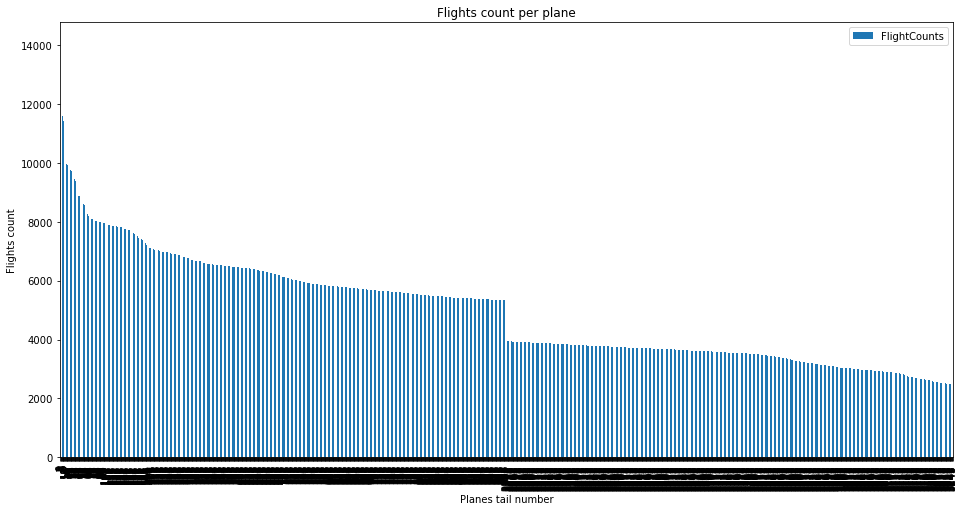

In [153]:
# Looking at how the flights count of our sampled planes is distributed
sample_planes_df.plot(kind="bar", figsize=(16,8))

# # Plot count of destination per planes
# destinations_count.plot(kind="bar", figsize=(16,6))

plt.xlabel("Planes tail number")
plt.ylabel("Flights count")
plt.title("Flights count per plane");

The planes we sampled have recorded a flight count ranging from 6000 to a little less than 12000 flights for thoses with the higher number of flights, and from 2400 to 4000 flights for those with the lesser number of flight.

We are interested in on-time performance per plane, so we will add to `sample_planes_df` the mean departure delay of each plane.

In [154]:
# Retrieve our sampled planes tails number
sample_planes_tailnum = sample_planes_df["TailNum"]
sample_planes_tailnum

0       N308SW
1       N478HA
2       N480HA
3       N479HA
4       N485HA
         ...  
3242    N17719
3243    N641AA
3244    N37293
3245    N249JB
3246    N632AA
Name: TailNum, Length: 2000, dtype: object

In [155]:
delay_variables

['DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'NASDelay',
 'LateAircraftDelay',
 'OtherDelay']

In [156]:
# Compute the mean delays of each of our sampled planes
mean_delays_per_plane = clean_flight_df[ ["TailNum"]+delay_variables ] \
                                  .query(" TailNum in {}".format(sample_planes_tailnum.to_list()))  \
                                  .groupby("TailNum") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="DepDelay" ,ascending=False)
mean_delays_per_plane

,TailNum,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
849,N514MJ,26.034392,9.125230,1.006301,3.585718,3.585718,13.217117,-30.520084
852,N515MJ,25.639538,9.424258,0.600945,4.453137,4.453137,12.824363,-31.755841
805,N502MJ,25.507949,9.115976,1.062809,4.630962,4.630962,12.301016,-31.741725
812,N504MJ,25.446201,9.456145,0.672106,4.454615,4.454615,12.131311,-31.168791
827,N508MJ,25.123022,8.871363,0.482899,4.301940,4.301940,12.789689,-30.747831
...,...,...,...,...,...,...,...,...
795,N486HA,-2.731583,0.479673,0.002459,0.004741,0.004741,0.453244,-0.944859
788,N477HA,-2.786660,0.449908,0.012096,0.021299,0.021299,0.369270,-0.873872
792,N481HA,-2.801640,0.484937,0.012085,0.018127,0.018127,0.437894,-0.971170
791,N480HA,-2.810767,0.466362,0.014030,0.016058,0.016058,0.546484,-1.058993


Now we will add the result of mean delays to `sample_planes_df`

In [157]:
# Merge mean delays result to our sampled planes
sample_planes_df = sample_planes_df.merge(mean_delays_per_plane,how="inner", left_on="TailNum", right_on="TailNum") \
                                   .sort_values(by="DepDelay" ,ascending=False)
sample_planes_df.head()

,TailNum,FlightCounts,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
1167,N514MJ,3809,26.034392,9.125230,1.006301,3.585718,3.585718,13.217117,-30.520084
1165,N515MJ,3809,25.639538,9.424258,0.600945,4.453137,4.453137,12.824363,-31.755841
1135,N502MJ,3837,25.507949,9.115976,1.062809,4.630962,4.630962,12.301016,-31.741725
1022,N504MJ,3922,25.446201,9.456145,0.672106,4.454615,4.454615,12.131311,-31.168791
1027,N508MJ,3918,25.123022,8.871363,0.482899,4.301940,4.301940,12.789689,-30.747831


In [158]:
# Rename the features in sample_planes_df to more appropriate names
sample_planes_df.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

sample_planes_df.head()

,TailNum,FlightCounts,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
1167,N514MJ,3809,26.034392,9.125230,1.006301,3.585718,3.585718,13.217117,-30.520084
1165,N515MJ,3809,25.639538,9.424258,0.600945,4.453137,4.453137,12.824363,-31.755841
1135,N502MJ,3837,25.507949,9.115976,1.062809,4.630962,4.630962,12.301016,-31.741725
1022,N504MJ,3922,25.446201,9.456145,0.672106,4.454615,4.454615,12.131311,-31.168791
1027,N508MJ,3918,25.123022,8.871363,0.482899,4.301940,4.301940,12.789689,-30.747831


Now we will search for relationships between the numeric features of `sample_planes_df`

In [159]:
# Correlation between the mean delay variables
sample_planes_df.corr()

,FlightCounts,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
FlightCounts,1.000000,-0.114222,-0.094152,0.082256,-0.523623,-0.523623,0.026374,0.382833
MeanDepDelay,-0.114222,1.000000,0.479230,0.305479,0.424318,0.424318,0.599365,-0.785123
MeanCarrierDelay,-0.094152,0.479230,1.000000,0.621718,0.021769,0.021769,-0.239163,-0.333829
MeanWeatherDelay,0.082256,0.305479,0.621718,1.000000,0.116835,0.116835,-0.436125,-0.249242
MeanNASDelay,-0.523623,0.424318,0.021769,0.116835,1.000000,1.000000,0.262431,-0.866029
MeanNASDelay,-0.523623,0.424318,0.021769,0.116835,1.000000,1.000000,0.262431,-0.866029
MeanLateAircraftDelay,0.026374,0.599365,-0.239163,-0.436125,0.262431,0.262431,1.000000,-0.497024
OtherDelay,0.382833,-0.785123,-0.333829,-0.249242,-0.866029,-0.866029,-0.497024,1.000000


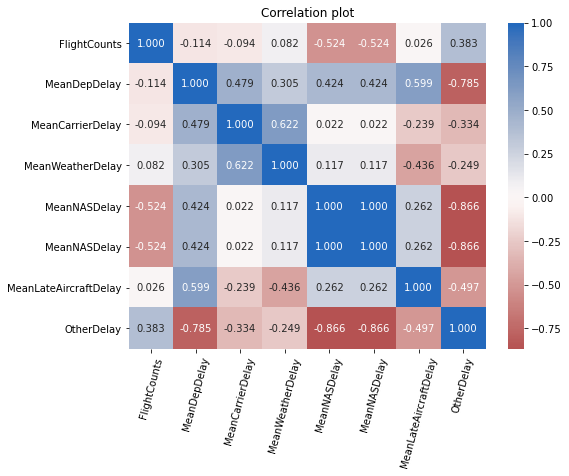

In [160]:
# Heatmap of the correlation in the previous cell
plt.figure(figsize = [8, 6])
sb.heatmap(sample_planes_df.corr(), annot = True, fmt = ".3f", cmap = "vlag_r", center = 0)
#plt.show()

plt.title("Correlation plot")

plt.xticks(rotation=75);

We can see that the number of flights of a plane is not correlated to its mean departure delay. So a plane on-time performance doesn't improve its flights count.       
Since we already saw the absence of correlation between `FlightCount` and `MeanDepDelay`, there is no use going further to explore their relationship.

<br/>

The mean delay related to carrier operations is correlated to the mean delays caused by weather. So for a given plane, the higher the delay caused by weather, the higher the delay related to carrier operations will be.
                
<br/> 

The mean NAS delay of a given plane is negatively correlated to its flight counts. That is to say, the weaker the delay related to NAS, the higher the number of flights a plane may make. It is worth pondering why.             


<br/>

We will also take note of the fact that mean departure delay of a given plane `MeanDepDelay` has a positive and high correlation with each of its delay reasons: carrier, weather, NAS, late aircraft.  This mean that for a given plane, the departure delay is related to each of those delay reasons.

<br/>        
                  
💡 *We will use the above plot, and the findings here in our explanatory analysis*

<a id="carrier-vs-depdelay"></a>
### Explore relationship between freight companies and departure delays

We are going to explore on-time performance of the freight companies [Read more...](#tailnum-exploration). The goal is to understand if on-time performance of planes, grouped by freight companies, differ from each others.             
To do so, we will compute and compare the mean on-time performance of planes grouped by freight companies.

In [161]:
# Recall the flights dataframe structure
clean_flight_df.head(8).T

,0,1,2,3,4,5,6,7
Year,2005,2005,2005,2005,2005,2005,2005,2005
Month,1,1,1,1,1,1,1,1
DayofMonth,28,15,19,31,19,31,3,6
DayOfWeek,5,6,3,1,3,1,1,4
DepTime,1603,1733,807,759,1008,1008,1821,2239
CRSDepTime,1605,1734,805,805,1010,1010,1605,1955
ArrTime,1741,1909,912,859,1240,1314,2056,51
CRSArrTime,1759,1914,910,910,1258,1258,1828,2223
UniqueCarrier,UA,UA,UA,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559,559,564,565


In [162]:
# Mean delays of planes groupbed per carrier
mean_delays_per_carrier = clean_flight_df[ ["UniqueCarrierDesc"]+delay_variables ] \
                                  .groupby("UniqueCarrierDesc") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="DepDelay" ,ascending=False)

mean_delays_per_carrier

,UniqueCarrierDesc,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
6,Atlantic Southeast Airlines,17.637066,8.262367,3.064043,4.820048,4.820048,2.336583,-23.303090
15,Mesa Airlines Inc.,14.405149,7.113139,0.649411,2.616858,2.616858,6.497436,-19.493701
14,JetBlue Airways,14.112793,3.075234,0.534728,7.266785,7.266785,7.829045,-25.972576
20,United Air Lines Inc.,13.066905,3.835629,0.422398,4.781349,4.781349,7.017973,-20.838698
5,American Eagle Airlines Inc.,12.818229,3.906169,0.902901,4.672946,4.672946,6.894867,-21.049829
0,AirTran Airways Corporation,12.368125,2.184800,0.143274,5.046056,5.046056,8.058647,-20.478833
18,Southwest Airlines Co.,12.304093,2.208318,0.439631,1.610370,1.610370,6.628416,-12.497105
4,American Airlines Inc.,12.267529,3.628055,1.027536,5.202703,5.202703,5.713186,-20.774184
1,Alaska Airlines Inc.,11.565889,5.192881,0.216086,2.751659,2.751659,6.203887,-17.116173
8,Continental Air Lines Inc.,11.304467,2.988633,0.705127,7.085121,7.085121,4.387411,-22.251413


In [163]:
# Renaming the features to give them more expressive names
mean_delays_per_carrier.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

mean_delays_per_carrier.head()

,UniqueCarrierDesc,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
6,Atlantic Southeast Airlines,17.637066,8.262367,3.064043,4.820048,4.820048,2.336583,-23.303090
15,Mesa Airlines Inc.,14.405149,7.113139,0.649411,2.616858,2.616858,6.497436,-19.493701
14,JetBlue Airways,14.112793,3.075234,0.534728,7.266785,7.266785,7.829045,-25.972576
20,United Air Lines Inc.,13.066905,3.835629,0.422398,4.781349,4.781349,7.017973,-20.838698
5,American Eagle Airlines Inc.,12.818229,3.906169,0.902901,4.672946,4.672946,6.894867,-21.049829


Let's observe the result in a plot

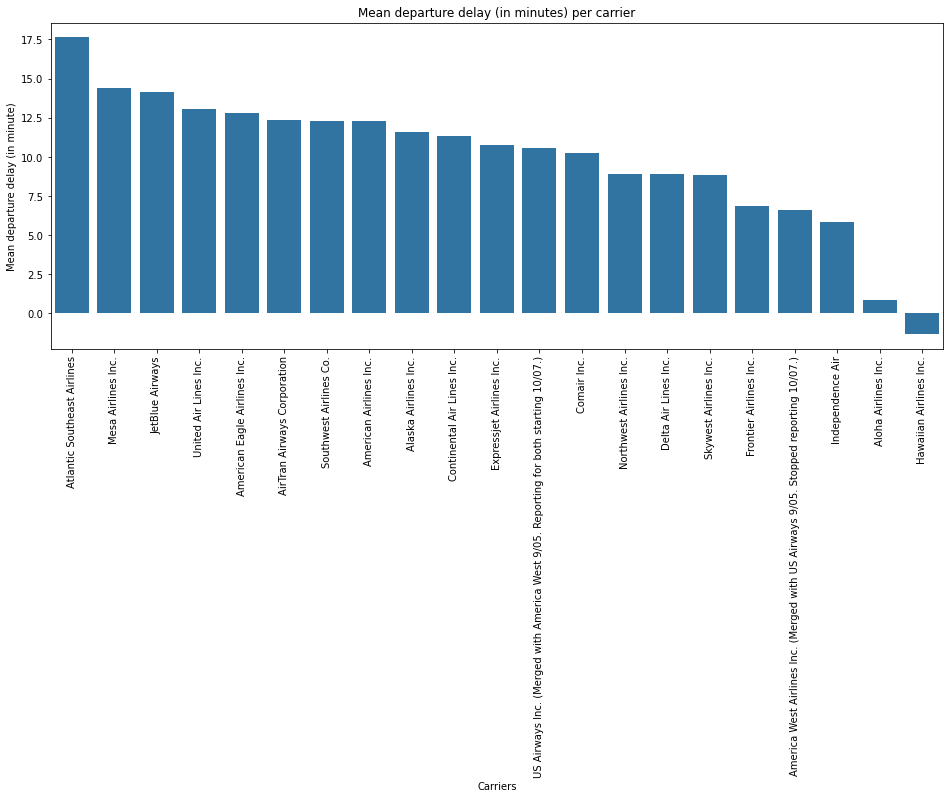

In [164]:
plt.figure(figsize=[16,6])
sb.barplot(data=mean_delays_per_carrier,x="UniqueCarrierDesc",y="MeanDepDelay", color=sb.color_palette()[0])

plt.xticks(rotation=90)

plt.xlabel("Carriers")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) per carrier");

This plot is showing that on-time performance of planes is related to their freight companies, since the performance from on company to another differ so much.

When taking a flight, a passenger should be interested in flights related to `Hawaiian Airlines Inc` and `Aloha Airlines Inc`, because their planes tend to take off faster than those of other companies. 

Nearly all companies planes tend to take-off on time. Even the least best performing company, `Atlantic Southeast Airlines`, planes tend to take-off at 17minute30, 2minutes higher than the threshold delay time.

💡 *We will bring the above plot, and its observations, into our future explanatory analysis.*

<!-- Now, we will observe how delay reasons is distributed around each of those companies.

TODO : plot the above plot, while using delay reasons as hue -->

<!-- Now we will investigate the possible relationship between the different delays reason when the planes are grouped by freight company. -->

In [165]:
# # Correlation plot
# plt.figure(figsize = [8, 6])
# sb.heatmap(mean_delays_per_carrier.corr(), annot = True, fmt = ".3f", cmap = "vlag_r", center = 0)
# #plt.show()

# plt.title("Correlation plot")

# plt.xticks(rotation=75);

<!-- The mean departure delay has a high and positive correlation to the mean value of delay reasons. This suggest that for each freight company, 

Here again, the mean departure delay is highly correlated to the mean value of delay reasons, which suggest that when taking freight companies into account, the departure delay is highly correlated to the delay reasons. -->

<a id="planetype-vs-depdelay"></a>
### Explore relationship between plane types and departure delays

In our preliminary exploration of departure delay per plane type, we have come to the conclusion that **`foreign corporations have higher departure delay than (national) Corporation.`** `And Indivual flights tend to have no departure delay; once again, this should be related to the fact that those flights are private one related to business-men.`. [Read more...](#categorical-vs-numerical).  

We are going to do in-depth exploration those findings.

In [166]:
# Count planes per type
planes_per_type_count = clean_flight_df["PlaneType"].value_counts()
planes_per_type_count

Corporation            16884195
Individual                63857
Foreign Corporation       48843
Co-Owner                  12975
Partnership                4145
Name: PlaneType, dtype: int64

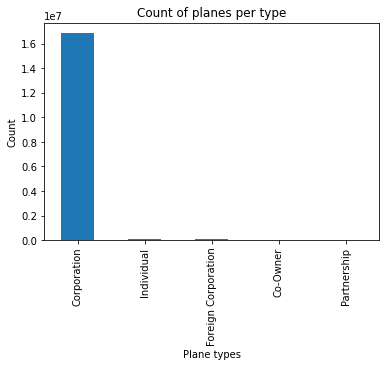

In [167]:
# Plot our results
planes_per_type_count.plot(kind="bar")

plt.xlabel("Plane types")
plt.ylabel("Count")
plt.title("Count of planes per type");

We will take note of the fact that we have higher number of (national) `Corporation` flights. Now let us explore the relationship between departure delay and plane types.

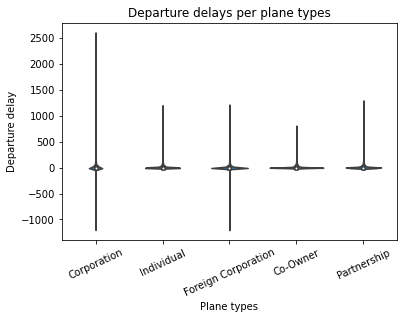

In [168]:
# Departure delays per plane types
sb.violinplot(data=clean_flight_df, x="PlaneType", y="DepDelay", color=sb.color_palette()[0]  )

plt.xticks(rotation=25)

plt.xlabel("Plane types")
plt.ylabel("Departure delay")
plt.title("Departure delays per plane types");

We are going to zoom-in in the y-axis, for a better view of the data distribution.

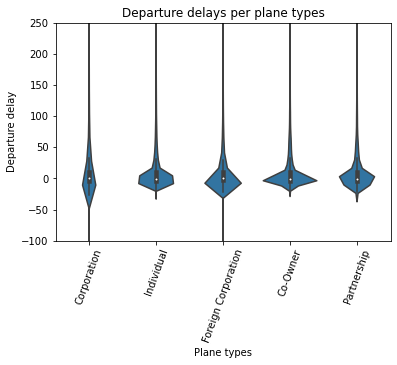

In [169]:
# Departure delays per plane types
sb.violinplot(data=clean_flight_df, x="PlaneType", y="DepDelay", color=sb.color_palette()[0] )

plt.xticks(rotation=70)
plt.ylim(-100,250)

plt.xlabel("Plane types")
plt.ylabel("Departure delay")
plt.title("Departure delays per plane types");

We will redefine the y-axis label of the plot in order to read more informations on how the data is distributed.

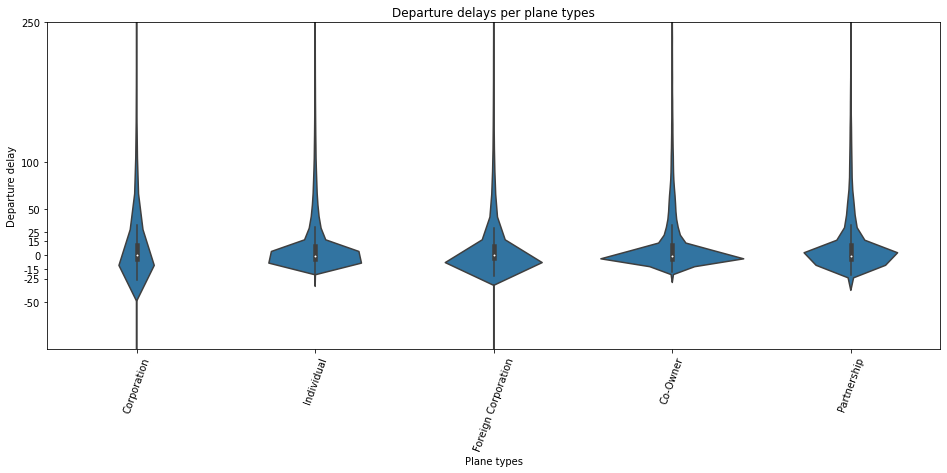

In [170]:
# Departure delays per plane types
plt.figure(figsize=[16,6])

sb.violinplot(data=clean_flight_df, x="PlaneType", y="DepDelay", color=sb.color_palette()[0] )

plt.xticks(rotation=70)
plt.ylim(-100,250)

yticks= {
    "values":[-50, -25, -15, 0, 15, 25, 50, 100, 250],
    "labels":[-50, -25, -15, 0, 15, 25, 50, 100, 250]
}
plt.yticks(yticks["values"], yticks["labels"])

plt.xlabel("Plane types")
plt.ylabel("Departure delay")
plt.title("Departure delays per plane types");

We can confirm that all plane types have nearly the same departure delay. Looking at the boxplot inside our violin-plot, we can see that those departure delays fall in the same range of values.
However, looking at the KDE of our violin-plot, the number of planes which tend to take-off at a given moment is different from one plane type to another :
* `Co-owner` planes for example have nearly all its departure delay concentrated at 0, with very small number of planes farther away from 0
* `Corporation` planes have their departure distributed from around -25minutes before the departure time to around 25minutes after the departure time


We can conclude that plane types is somewhat correlated to departure delay.

<div id="aircrafttype-vs-depdelay"></div>

### Explore relationship between aircraft types and departure delays

In our preliminary exploration of departure delay per aircraft type, we have come to the conclusion that `Planes with [Fixed Wing Multi-Engine] departure delays are a little higher than those of other types of aircraft.`. [Read more...](#categorical-vs-numerical).  

We are going to explore that finding more in-depth.

In [171]:
# Count planes per aircraft type
planes_per_aircraftype_count = clean_flight_df["AircraftType"].value_counts()
planes_per_aircraftype_count

Fixed Wing Multi-Engine     16921598
Fixed Wing Single-Engine       78185
Balloon                         8207
Rotorcraft                      6025
Name: AircraftType, dtype: int64

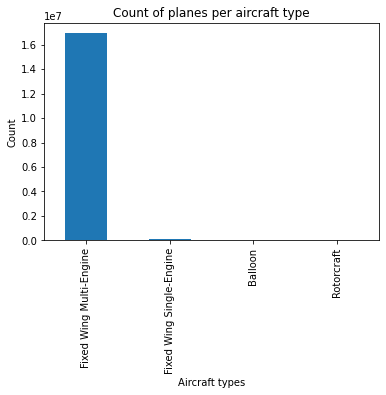

In [172]:
# Observing the result in a visual
planes_per_aircraftype_count.plot(kind="bar")

plt.xlabel("Aircraft types")
plt.ylabel("Count")
plt.title("Count of planes per aircraft type");

Nearly all planes have a `Fixed Wing Multi-Engine` motor. And this plot make me recall the one of `planes_per_type_count`. Let us check that again.

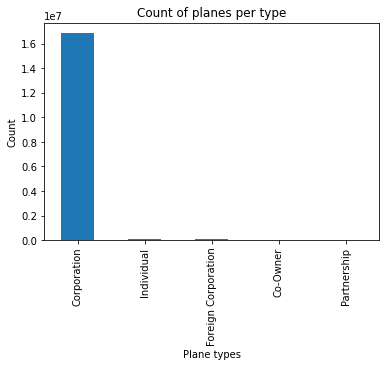

In [173]:
# Plot planes count per type
planes_per_type_count.plot(kind="bar")

plt.xlabel("Plane types")
plt.ylabel("Count")
plt.title("Count of planes per type");

In [174]:
# Look at the planes_per_type_count, to confirm the exact number
planes_per_type_count

Corporation            16884195
Individual                63857
Foreign Corporation       48843
Co-Owner                  12975
Partnership                4145
Name: PlaneType, dtype: int64

The last two plots, and the last two series (`planes_per_type_count` and `planes_per_aircraftype_count`) show that `Corporation` are mainly using `Fixeg Winged Multi-Engine`, because the numbers are nearly the same.

**So far, we have explored our dataset based on what the data is telling us. Now however, we are going to try to answer key questions for us, the one asked in the introduction of the notebook.**

<div id="depdelay-and-cancellation-per-cities"></div>

### Are there certain departure cities that are home to more delays or cancellations ?


We will explore the relationship between departure delay and cities, and between cancellations and cities. We want to understand which city are performing the best and which are performing the poorest.

In [175]:
# Recall the structure of our dataset
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


In [176]:
# Observing the different values regarding flight cancellation
clean_flight_df["Cancelled"].unique()

array([0], dtype=int64)

In [177]:
# Observing the datatype of the values of Cancelled feature
clean_flight_df["Cancelled"].dtype

dtype('int64')

Although the datatype is `int`, `0` should stand for `False`(a boolean) indicating that the flight was not cancelled.
Since all flights have a value stating a status of `not cancelled`, we will not be able to perform analysis regarding cancellation.
We will mark this as a limitation in our work.

Now let us move on to the analysis of delays per city

In [178]:
delay_variables

['DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'NASDelay',
 'LateAircraftDelay',
 'OtherDelay']

We will add departure airports additional information to our main dataframe.

In [179]:
clean_flight_df.shape

(17014015, 39)

In [180]:
# airport additional informations overview
airport_df

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944
...,...,...,...,...,...,...,...
3371,ZEF,Elkin Municipal,Elkin,NC,USA,36.280024,-80.786069
3372,ZER,Schuylkill Cty/Joe Zerbey,Pottsville,PA,USA,40.706449,-76.373147
3373,ZPH,Zephyrhills Municipal,Zephyrhills,FL,USA,28.228065,-82.155916
3374,ZUN,Black Rock,Zuni,NM,USA,35.083227,-108.791777


In [181]:
# Merge departure airports informations to flights main dataframe
clean_flight_with_departurecity = clean_flight_df.merge(airport_df, how="inner", left_on="Origin", right_on="iata")
clean_flight_with_departurecity.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,2,3
DayofMonth,28,1,13,2,22
DayOfWeek,5,6,4,3,2
DepTime,1603,1306,1807,1554,805
CRSDepTime,1605,1310,1605,1605,810
ArrTime,1741,1454,2103,1741,949
CRSArrTime,1759,1458,1759,1759,1003
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,539,541,541,529


In [182]:
# clean_flight_with_departurecity.head().T

In [183]:
clean_flight_with_departurecity.shape

(17001810, 46)

Now we will compute the mean departure variables per city.

In [184]:
# Departure delay per city
depdelays_per_city = clean_flight_with_departurecity[ ["city"]+delay_variables ] \
                                  .groupby("city") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="DepDelay" ,ascending=False)

depdelays_per_city

,city,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
56,Clarksburg,130.000000,130.000000,0.000000,0.000000,0.000000,0.000000,-130.000000
200,Ogden,108.000000,87.000000,0.000000,0.000000,0.000000,0.000000,-87.000000
52,Cheyenne,105.000000,0.000000,44.000000,0.000000,0.000000,0.000000,-44.000000
185,Muskegon,47.071429,21.071429,6.714286,2.000000,2.000000,15.928571,-47.714286
187,Nantucket,37.600904,4.329819,0.688253,24.174699,24.174699,14.906627,-68.274096
...,...,...,...,...,...,...,...,...
210,Pellston,-2.000000,0.000000,0.000000,31.000000,31.000000,0.000000,-62.000000
274,Visalia,-2.050000,1.505263,0.089474,0.239474,0.239474,0.544737,-2.618421
218,Pocatello,-2.354656,1.357287,0.631174,0.568421,0.568421,1.463968,-4.589271
117,Hilo,-2.589956,0.875100,0.028788,0.077186,0.077186,1.400410,-2.458671


In [185]:
# Renaming the features to give them more appropriate names
depdelays_per_city.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

depdelays_per_city.head()

,city,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
56,Clarksburg,130.000000,130.000000,0.000000,0.000000,0.000000,0.000000,-130.000000
200,Ogden,108.000000,87.000000,0.000000,0.000000,0.000000,0.000000,-87.000000
52,Cheyenne,105.000000,0.000000,44.000000,0.000000,0.000000,0.000000,-44.000000
185,Muskegon,47.071429,21.071429,6.714286,2.000000,2.000000,15.928571,-47.714286
187,Nantucket,37.600904,4.329819,0.688253,24.174699,24.174699,14.906627,-68.274096


Let us observe our result on visuals. With the number of rows we have, we expect the x-axis will not be informative. But we can still observe the variation of data in the y-axis.

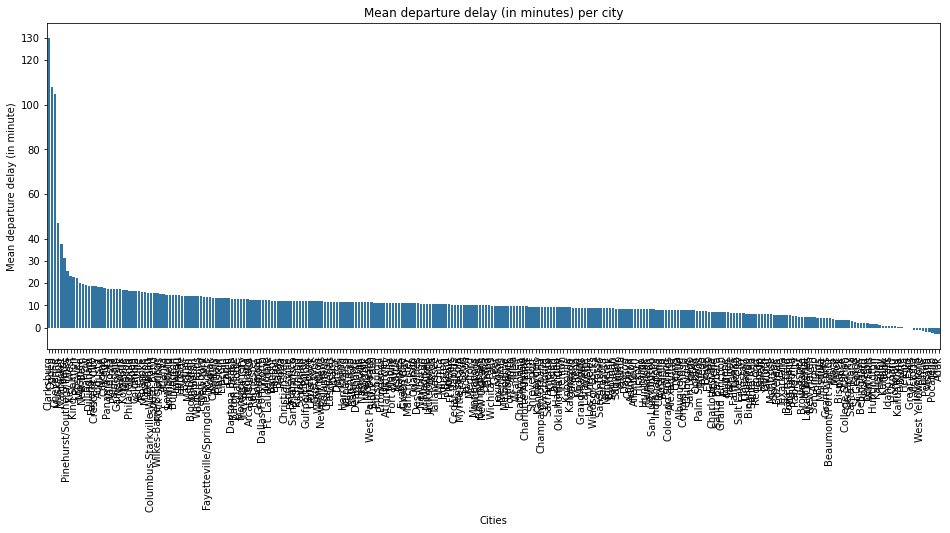

In [186]:
# Plot MeanDepDelay by departure city

plt.figure(figsize=[16,6])
sb.barplot(data=depdelays_per_city,x="city",y="MeanDepDelay", color=sb.color_palette()[0])

yticks= {
    "values":[0, 10, 20, 30, 40, 60, 80, 100, 120, 130],
    "labels":[0, 10, 20, 30, 40, 60, 80, 100, 120, 130]
}

plt.xticks(rotation=90)
plt.yticks(yticks["values"], yticks["labels"])

plt.xlabel("Cities")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) per city");

From the content of `depdelays_per_city["DepDelay"]` and the above plot, we can see that there are cities with planes taking-off 02 to 03 minutes before the scheduled time, and cities where planes are late to take-off by 100 to 130 minutes. This means that departure delay is definitely related to the city.      



It would be good to explore the question a little more by associating the number of passengers of the planes, the number of people living in the city, and the dimension of the aiport (small/big airport?), but we don't have the data which allow that. We will mark that as a limitation in the work.

From the plot, we can observe 03 groups of performance:
* on the left side of the plot, the cities where planes are taking-off after 18 minutes to over 120 minutes of the scheduled time: worst performing group
* on the middle side of the plot, cities where planes are taking-off around 15 minutes after the scheduled time
* on the right side of the plot, cities where planes are taking off before the scheduled time up to around 10 minutes maximum after the scheduled time.                   

We may not be able to observe in detail the concerned cities on the above plot, but we can still observe the worst performing ones in another plot.

We will retrieve the cities with the worst departure delay (depature delay from 20 minute will be considered as worst)

In [187]:
# Cities with worst departure delay
cities_with_top_depdelay = depdelays_per_city[ depdelays_per_city["MeanDepDelay"]>=20 ]
print(cities_with_top_depdelay.shape)
print(cities_with_top_depdelay.head())
print(cities_with_top_depdelay.tail())

(11, 8)
           city  MeanDepDelay  MeanCarrierDelay  MeanWeatherDelay  \
56   Clarksburg    130.000000        130.000000          0.000000   
200       Ogden    108.000000         87.000000          0.000000   
52     Cheyenne    105.000000          0.000000         44.000000   
185    Muskegon     47.071429         21.071429          6.714286   
187   Nantucket     37.600904          4.329819          0.688253   

     MeanNASDelay  MeanNASDelay  MeanLateAircraftDelay  OtherDelay  
56       0.000000      0.000000               0.000000 -130.000000  
200      0.000000      0.000000               0.000000  -87.000000  
52       0.000000      0.000000               0.000000  -44.000000  
185      2.000000      2.000000              15.928571  -47.714286  
187     24.174699     24.174699              14.906627  -68.274096  
                         city  MeanDepDelay  MeanCarrierDelay  \
216  Pinehurst/Southern Pines     25.432787         19.085246   
136                  Key West    

We have 11 city with a mean departure delay starting from 20. We will observe them on a plot.

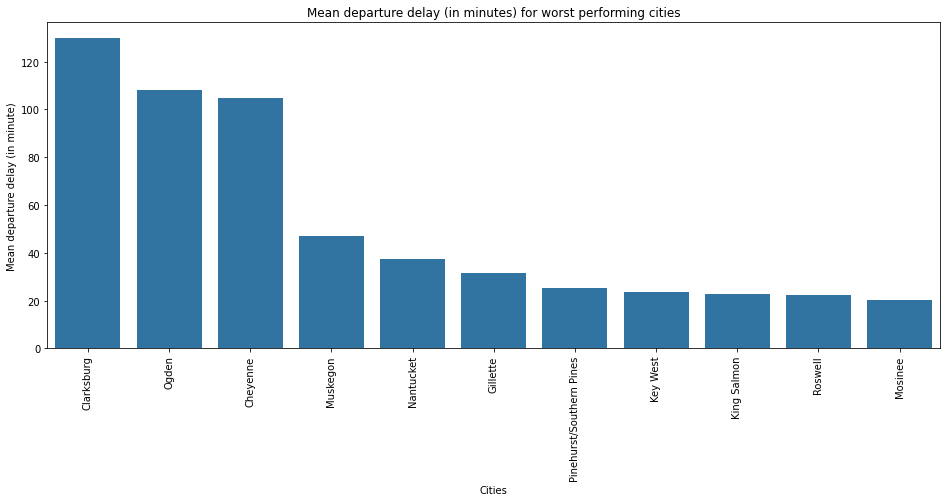

In [188]:
# Plot MeanDepDelay by departure city

plt.figure(figsize=[16,6])
sb.barplot(data=cities_with_top_depdelay,x="city",y="MeanDepDelay", color=sb.color_palette()[0])

# yticks= {
#     "values":[0, 10, 20, 30, 40, 60, 80, 100, 120, 130],
#     "labels":[0, 10, 20, 30, 40, 60, 80, 100, 120, 130]
# }

plt.xticks(rotation=90)
#plt.yticks(yticks["values"], yticks["labels"])

plt.xlabel("Cities")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) for worst performing cities");

We can see the high difference in departure delay from the first group of three cities on the left side, the next group of three cities in the middle, and the last group of five cities on the right.
Now, we know which cities to expect high departure delays from. 

💡 *We will use the above plot, and the findings here, in the explanatory analysis*

<div id="explore-flight-per-time"></div>

### What are the preferred day periods for flights to occur ?  


We are interested to know which periods of the day (morning, night, afternoon, ...) is more subject to delay and cancellation.
Here is how we will proceed:
1. Create a new `DepDateTime` feature, based on the already existing features of `Year, Month, DepTime, DayofMonth` to make our operation easier
1. Create a new feature `DepPeriod`, which will contain the period the flight is taking place, namely `morning, evening, night, ...`
1. Compute the mean depature delay per `DayPeriod`

In [189]:
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


In [190]:
# Create a new datetime feature named DepDateTime, which will contain the date and time of the departure

# clean_flight_df = engineer_datetime_feature(clean_flight_df, new_datetime_column="DepDateTime", time_column="DepTime")
# clean_flight_df.head(3).T

Once again, we are obtaining an `insuffiant memory` error when running the code above (this should be related to the amount of data we are working with), so we will not be able to give an anwser to the question of this section. We will mark this a limitation in our work.       
We commented the said code in order to avoid error when running the notebook.

<div id="explore-depdelay-per-week-and-month"></div>

### When is the best day of week or month of year to fly to minimise delays ?  


We will explore which months in a year, and which weekdays have the less departure delay.

**Comparing the departure delays per months**

In [191]:
# Count of flights per months
clean_flight_df["Month"].value_counts()

3     1541071
4     1470334
8     1467448
7     1447893
10    1425767
5     1416287
6     1398619
1     1388029
12    1387934
11    1380004
9     1358330
2     1332299
Name: Month, dtype: int64

We are going to convert the months from number to literal form.

In [192]:
# Create a new column which contain the string version of the actual months
clean_flight_df["LiteralMonth"]= clean_flight_df["Month"].astype(str)
clean_flight_df["LiteralMonth"].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

In [193]:
ordered_months= ["Jan","Feb","March","Apr","May","June","Jul","Aug","Sept","Oct","Nov","Dec"]

In [194]:
# Replace months in number format by months in litteral format
clean_flight_df["LiteralMonth"] = clean_flight_df["LiteralMonth"].replace(
    ["1","2","3","4","5","6","7","8","9","10","11","12"],
    ordered_months
)
clean_flight_df["LiteralMonth"].unique()

array(['Jan', 'Feb', 'March', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sept',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [195]:
# Setting order in our month feature
ordered_months_variable = pd.api.types.CategoricalDtype(ordered = True, categories = ordered_months)
clean_flight_df["LiteralMonth"] = clean_flight_df["LiteralMonth"].astype(ordered_months_variable)
clean_flight_df["LiteralMonth"].dtypes

CategoricalDtype(categories=['Jan', 'Feb', 'March', 'Apr', 'May', 'June', 'Jul', 'Aug',
                  'Sept', 'Oct', 'Nov', 'Dec'],
, ordered=True)

We can now compute the flights count per month.

In [196]:
# Count of flights per month
flights_count_per_month = clean_flight_df["LiteralMonth"].value_counts().sort_index()
flights_count_per_month

Jan      1388029
Feb      1332299
March    1541071
Apr      1470334
May      1416287
June     1398619
Jul      1447893
Aug      1467448
Sept     1358330
Oct      1425767
Nov      1380004
Dec      1387934
Name: LiteralMonth, dtype: int64

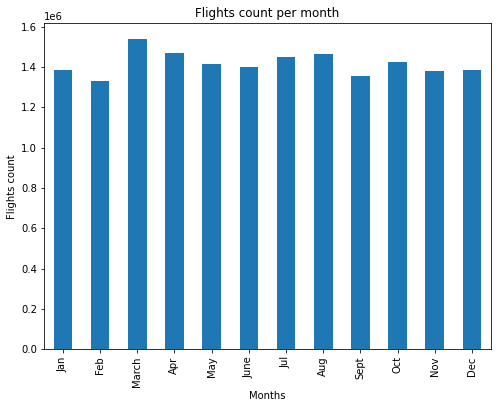

In [197]:
# Plot the flights count per month
flights_count_per_month.plot(kind="bar", figsize=(8,6))

plt.xlabel("Months")
plt.ylabel("Flights count")
plt.title("Flights count per month");

The number of flights per month is nearly the same for each month. 
We will not that March however has computed the highest number of flights, and February the less.

In [198]:
# Mean departure delay per month
depdelays_per_month = clean_flight_df[ ["LiteralMonth"]+delay_variables ] \
                                  .groupby("LiteralMonth") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="DepDelay" ,ascending=False)

depdelays_per_month

,LiteralMonth,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
1,Feb,14.275961,4.851190,1.120969,5.202457,5.202457,6.389690,-22.766763
11,Dec,13.966051,4.700445,0.924524,4.708050,4.708050,6.019148,-21.060218
6,Jul,13.888303,4.458597,1.045561,4.547897,4.547897,6.237105,-20.837056
2,March,13.763841,4.605768,0.824234,4.886561,4.886561,6.150135,-21.353260
5,June,13.372117,4.288252,1.053214,4.632590,4.632590,5.883881,-20.490528
0,Jan,13.366590,4.712376,1.059343,5.133706,5.133706,5.888605,-21.927736
7,Aug,11.322705,3.967165,0.803739,3.868936,3.868936,5.122351,-17.631126
3,Apr,10.494060,3.865063,0.614807,4.082156,4.082156,4.822291,-17.466472
9,Oct,8.414641,3.096035,0.572662,3.835425,3.835425,3.913390,-15.252935
10,Nov,7.842616,2.958121,0.469127,3.482308,3.482308,3.497448,-13.889312


In [199]:
# Renaming the features to give them more appropriate names
depdelays_per_month.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

depdelays_per_month.head()

,LiteralMonth,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
1,Feb,14.275961,4.851190,1.120969,5.202457,5.202457,6.389690,-22.766763
11,Dec,13.966051,4.700445,0.924524,4.708050,4.708050,6.019148,-21.060218
6,Jul,13.888303,4.458597,1.045561,4.547897,4.547897,6.237105,-20.837056
2,March,13.763841,4.605768,0.824234,4.886561,4.886561,6.150135,-21.353260
5,June,13.372117,4.288252,1.053214,4.632590,4.632590,5.883881,-20.490528


A quick remark is that February, which has recorded the less flights, has the highest mean delay.

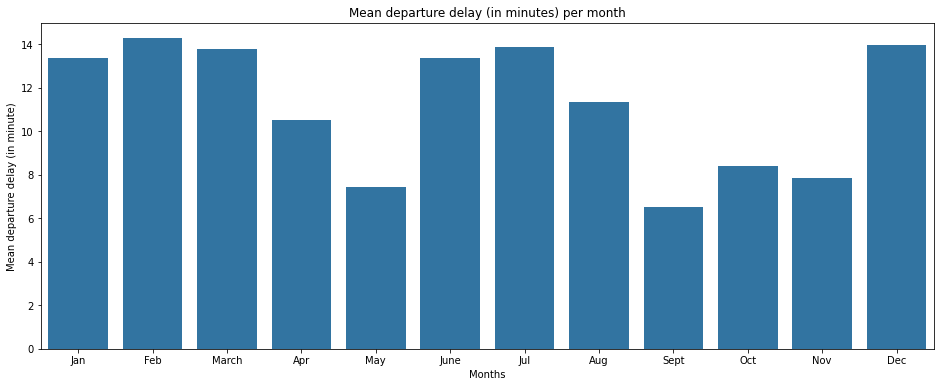

In [200]:
# Plot the mean departure delay per month

plt.figure(figsize=[16,6])

sb.barplot(data=depdelays_per_month,x="LiteralMonth",y="MeanDepDelay", color=sb.color_palette()[0])

# plt.xticks(rotation=90)

plt.xlabel("Months")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) per month");

The plot is telling us the mean departure delay we may expect for each month. Overall, the performance per month is good since there is no departure delay over the threshold of 15 minutes.        
May and September have the less departure delay, followed by November and October. 

We can remark that the months with higher departure delay seem somewhat concordant to usual holiday periods.

<br/>


💡 *We will bring this plot, and its findings in the explanotory analysis.*

**Comparing the departure delays per weekdays**

In [201]:
# Count of flights per weekday
clean_flight_df["DayOfWeek"].value_counts()

5    2527439
1    2513575
4    2502279
3    2471572
2    2454252
7    2390969
6    2153929
Name: DayOfWeek, dtype: int64

In [202]:
# Create a new column which contain the string version of the actual weekdays
clean_flight_df["LiteralDayOfWeek"]= clean_flight_df["DayOfWeek"].astype(str)
clean_flight_df["LiteralDayOfWeek"].unique()

array(['5', '6', '3', '1', '4', '2', '7'], dtype=object)

In [203]:
ordered_days= ["Mon","Tue","Wed","Thurs","Frid","Sat","Sun"]

In [204]:
# Replace weekdays in number format by weekdays in literal format
clean_flight_df["LiteralDayOfWeek"] = clean_flight_df["LiteralDayOfWeek"].replace(
    ["1","2","3","4","5","6","7"],
    ordered_days
)
clean_flight_df["LiteralDayOfWeek"].unique()

array(['Frid', 'Sat', 'Wed', 'Mon', 'Thurs', 'Tue', 'Sun'], dtype=object)

In [205]:
# Setting order in our weekdays feature
ordered_weekdays_variable = pd.api.types.CategoricalDtype(ordered = True, categories = ordered_days)
clean_flight_df["LiteralDayOfWeek"] = clean_flight_df["LiteralDayOfWeek"].astype(ordered_weekdays_variable)
clean_flight_df["LiteralDayOfWeek"].dtypes

CategoricalDtype(categories=['Mon', 'Tue', 'Wed', 'Thurs', 'Frid', 'Sat', 'Sun'], ordered=True)

In [206]:
# Count of flights per weekdays
flights_count_per_weekday = clean_flight_df["LiteralDayOfWeek"].value_counts().sort_index()
flights_count_per_weekday

Mon      2513575
Tue      2454252
Wed      2471572
Thurs    2502279
Frid     2527439
Sat      2153929
Sun      2390969
Name: LiteralDayOfWeek, dtype: int64

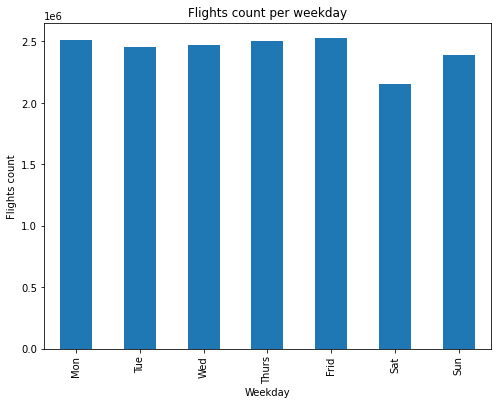

In [207]:
# Plot the flights count per weekday
flights_count_per_weekday.plot(kind="bar", figsize=(8,6))

plt.xlabel("Weekday")
plt.ylabel("Flights count")
plt.title("Flights count per weekday");

We have many flights each day. And their numbers are nearly the same for each weekday.

In [208]:
# Mean departure delay per weekday
depdelays_per_weekday = clean_flight_df[ ["LiteralDayOfWeek"]+delay_variables ] \
                                  .groupby("LiteralDayOfWeek") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="DepDelay" ,ascending=False)

depdelays_per_weekday

,LiteralDayOfWeek,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
4,Frid,13.751094,4.407768,0.886176,4.866531,4.866531,6.212718,-21.239725
3,Thurs,12.700718,4.076685,0.910663,5.017698,5.017698,5.890478,-20.913223
0,Mon,11.702676,3.935748,0.813609,4.290784,4.290784,5.309632,-18.640557
6,Sun,11.415517,4.188950,0.768544,3.788391,3.788391,5.004328,-17.538605
2,Wed,10.486239,3.604972,0.805059,4.472995,4.472995,4.874506,-18.230528
1,Tue,9.342711,3.404251,0.709241,4.158215,4.158215,4.287225,-16.717146
5,Sat,8.901228,3.962830,0.618851,2.643239,2.643239,3.649286,-13.517446


In [209]:
# Renaming the features to give them more appropriate names
depdelays_per_weekday.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

depdelays_per_weekday.head()

,LiteralDayOfWeek,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
4,Frid,13.751094,4.407768,0.886176,4.866531,4.866531,6.212718,-21.239725
3,Thurs,12.700718,4.076685,0.910663,5.017698,5.017698,5.890478,-20.913223
0,Mon,11.702676,3.935748,0.813609,4.290784,4.290784,5.309632,-18.640557
6,Sun,11.415517,4.188950,0.768544,3.788391,3.788391,5.004328,-17.538605
2,Wed,10.486239,3.604972,0.805059,4.472995,4.472995,4.874506,-18.230528


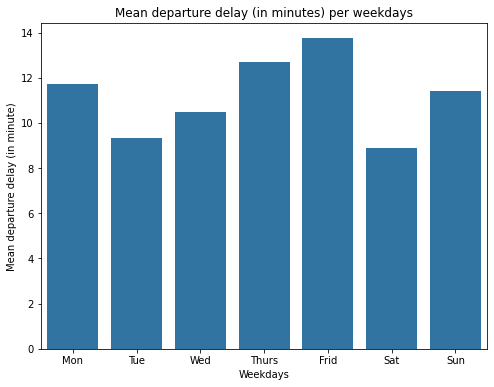

In [210]:
# Plot the mean departure delay per weekday

plt.figure(figsize=[8,6])

sb.barplot(data=depdelays_per_weekday,x="LiteralDayOfWeek",y="MeanDepDelay", color=sb.color_palette()[0])

# plt.xticks(rotation=90)

plt.xlabel("Weekdays")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) per weekdays");

The overall on-time performance of planes per weekday is also good: there is no delay over the threshold of 15 minutes.

Thursday and Friday have the higher departure delay, followed by Monday. Maybe people are moving from cities to countriside (on Thursday and Friday) for holidays, or from countryside to cities (on Monday) in order to work. This large influx of people those days causes congestion in the pre-flights activities which in turn is the root of a higher departure delay (recall that we saw a positive correlation between the mean departure delay and mean carrier delay).

<br/>

💡 *We will use the above plot, and its insights in the explanatory analysis*

<div id="depdelay-evolution-by-years"></div>

### Are there any changes over multiple years ?


We are interested to know how departure delay evolved over the years, although we don't expect to gain a definitive conclusion from it since our analysis doesn't span over many years.                  
In order to have an answer, we will compute the mean departure delay per year, and compare them.

In [211]:
# Mean departure delay per years
depdelays_per_year = clean_flight_df[ ["Year"]+delay_variables ] \
                                  .groupby("Year") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="DepDelay" ,ascending=False)

depdelays_per_year

,Year,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
3,2008,47.241814,15.250868,2.932376,16.248842,16.248842,21.073092,-71.754020
2,2007,11.286603,3.854745,0.753035,3.886481,3.886481,5.241021,-17.621763
1,2006,10.154176,3.635765,0.719781,3.954132,3.954132,4.616208,-16.880017
0,2005,8.614364,3.203793,0.694805,3.651032,3.651032,3.662155,-14.862816


In [212]:
# Renaming the features to give them more appropriate names
depdelays_per_year.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

depdelays_per_year.head()

,Year,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
3,2008,47.241814,15.250868,2.932376,16.248842,16.248842,21.073092,-71.754020
2,2007,11.286603,3.854745,0.753035,3.886481,3.886481,5.241021,-17.621763
1,2006,10.154176,3.635765,0.719781,3.954132,3.954132,4.616208,-16.880017
0,2005,8.614364,3.203793,0.694805,3.651032,3.651032,3.662155,-14.862816


Let's observe our result in a plot

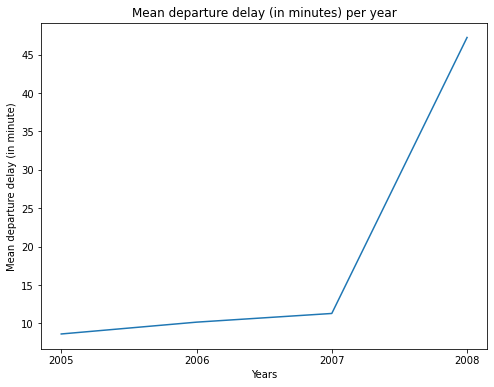

In [213]:
plt.figure(figsize=[8,6])

sb.lineplot(data=depdelays_per_year,x="Year",y="MeanDepDelay", color=sb.color_palette()[0])
ticks = np.arange(2005,2009)

xticks= {
    "values":ticks.tolist(),
    "labels":ticks.tolist()
}
# plt.xticks(rotation=90)
plt.xticks(xticks["values"], xticks["labels"])


plt.xlabel("Years")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) per year");

We have a slow and stable increase of departure delays from 2005 to 2007, followed by a very abrupt and high increase in 2008.                 
It is worth wondering what happen in 2008 to explain such a change. It would also be interesting to knwo if the departure delays decreased after 2008, or if the increase continued or stayed stable, and by how much. Due to insufficient data, we will not be able to answer either of these question.

<div id="depdelay-vs-planeage"></div>

### Do older planes suffer more delays ?

We are trying to understand if the older the plane, the higher the departure delay. In order to do that, we will base our analysis on the mean departure delay per plane age.

In [214]:
clean_flight_df.head().T

,0,1,2,3,4
Year,2005,2005,2005,2005,2005
Month,1,1,1,1,1
DayofMonth,28,15,19,31,19
DayOfWeek,5,6,3,1,3
DepTime,1603,1733,807,759,1008
CRSDepTime,1605,1734,805,805,1010
ArrTime,1741,1909,912,859,1240
CRSArrTime,1759,1914,910,910,1258
UniqueCarrier,UA,UA,UA,UA,UA
FlightNum,541,557,559,559,559


Let us understand the age of planes in our dataset.

In [215]:
# Count of flights per plane age
clean_flight_df["PlaneAge"].value_counts()

7.0       1660170
6.0       1345461
8.0       1304084
5.0       1254208
9.0       1246532
4.0       1046498
10.0      1028564
3.0        739467
20.0       585553
12.0       569324
17.0       544847
11.0       527254
18.0       510227
16.0       508463
21.0       499639
14.0       485691
13.0       467950
19.0       451113
23.0       383917
15.0       381488
22.0       341580
2.0        340065
24.0       104593
1.0        103858
40.0       102444
41.0        60248
25.0        57547
39.0        52232
29.0        46714
32.0        38625
33.0        38478
30.0        36277
28.0        31717
31.0        20747
2008.0      15820
26.0        14307
35.0        12458
38.0         8896
49.0         7703
42.0         5494
45.0         5017
34.0         5017
37.0         4537
46.0         4249
44.0         4241
43.0         3907
51.0         3014
0.0          2125
52.0          852
36.0          803
Name: PlaneAge, dtype: int64

2008 as an age should come from planes where creation year was not registered. We will filter them out in order to answer the question in this section.

In [216]:
flights_with_planeage = clean_flight_df[ clean_flight_df["PlaneAge"] != 2008 ]
flights_with_planeage["PlaneAge"].unique()

array([16., 20., 18., 17., 21.,  6.,  7., 15., 12., 10., 11.,  8., 14.,
        9., 13., 22., 19.,  4., 24.,  5., 23.,  3.,  2., 26., 25.,  1.,
        0., 41., 33., 29., 32., 31., 28., 39., 30., 40., 38., 35., 37.,
       42., 51., 45., 34., 52., 36., 44., 49., 46., 43.])

In [217]:
# Flights count per plane ages
flights_count_per_planeage = flights_with_planeage["PlaneAge"].value_counts().sort_index(ascending=True)
flights_count_per_planeage

0.0        2125
1.0      103858
2.0      340065
3.0      739467
4.0     1046498
5.0     1254208
6.0     1345461
7.0     1660170
8.0     1304084
9.0     1246532
10.0    1028564
11.0     527254
12.0     569324
13.0     467950
14.0     485691
15.0     381488
16.0     508463
17.0     544847
18.0     510227
19.0     451113
20.0     585553
21.0     499639
22.0     341580
23.0     383917
24.0     104593
25.0      57547
26.0      14307
28.0      31717
29.0      46714
30.0      36277
31.0      20747
32.0      38625
33.0      38478
34.0       5017
35.0      12458
36.0        803
37.0       4537
38.0       8896
39.0      52232
40.0     102444
41.0      60248
42.0       5494
43.0       3907
44.0       4241
45.0       5017
46.0       4249
49.0       7703
51.0       3014
52.0        852
Name: PlaneAge, dtype: int64

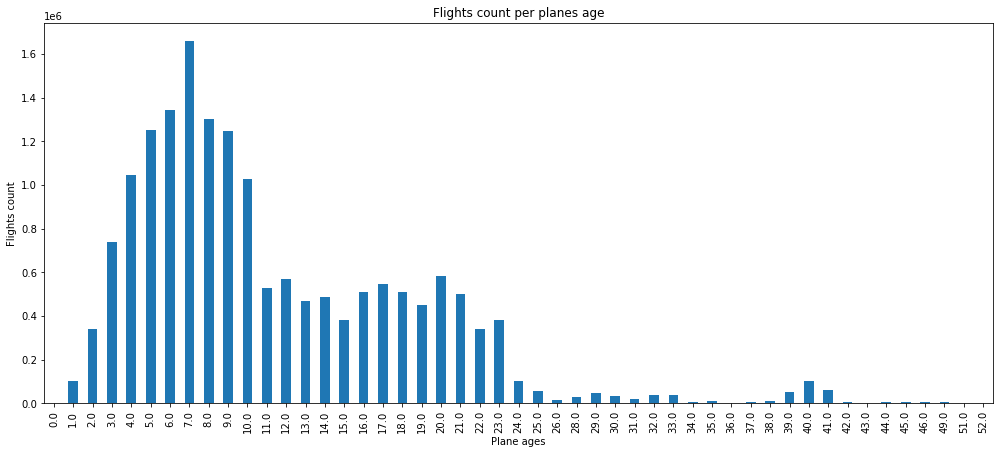

In [218]:
# Plot the flights count per age
flights_count_per_planeage.plot(kind="bar", figsize=(17,7))

plt.xticks(rotation=90)

plt.xlabel("Plane ages")
plt.ylabel("Flights count")
plt.title("Flights count per planes age");

Curiously, the planes with the highest number of flights are the younger ones. When planes arrive in their 20s, they tend to have the number of their flights decrease.

In [219]:
# Mean departure delay per plane ages
depdelays_per_planeage = flights_with_planeage[ ["PlaneAge"]+delay_variables ] \
                                  .groupby("PlaneAge") \
                                  .mean() \
                                  .reset_index() \
                                  .sort_values(by="PlaneAge" ,ascending=True) 
                                  #.sort_values(by="DepDelay" ,ascending=False)

depdelays_per_planeage

,PlaneAge,DepDelay,CarrierDelay,WeatherDelay,NASDelay,NASDelay,LateAircraftDelay,OtherDelay
0,0.0,46.622588,13.957647,3.506353,17.468706,17.468706,20.007059,-72.408471
1,1.0,15.138834,3.737507,0.776387,5.315498,5.315498,7.459647,-22.604537
2,2.0,13.130740,3.839037,0.646659,4.514846,4.514846,6.738203,-20.253590
3,3.0,12.208566,3.972672,0.767075,4.317560,4.317560,5.660092,-19.034959
4,4.0,11.863339,3.888138,0.872176,4.179561,4.179561,5.381243,-18.500678
5,5.0,11.431428,4.742491,1.125485,4.062641,4.062641,4.361171,-18.354428
6,6.0,11.254769,4.232045,0.940481,4.333862,4.333862,4.959871,-18.800120
7,7.0,9.718966,3.487331,0.742196,4.057804,4.057804,4.581762,-16.926896
8,8.0,10.726718,3.560024,0.773047,4.692895,4.692895,5.028142,-18.747002
9,9.0,11.260634,3.962417,0.870713,4.464766,4.464766,4.961130,-18.723792


In [220]:
# Renaming the features to give them more appropriate names
depdelays_per_planeage.rename(columns={
    "DepDelay":"MeanDepDelay",
    "CarrierDelay": "MeanCarrierDelay",
    "WeatherDelay": "MeanWeatherDelay",
    "NASDelay":"MeanNASDelay",
    "SecurityDelay" : "MeanSecurityDelay",
    "LateAircraftDelay": "MeanLateAircraftDelay"
},inplace=True)

depdelays_per_planeage.head()

,PlaneAge,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
0,0.0,46.622588,13.957647,3.506353,17.468706,17.468706,20.007059,-72.408471
1,1.0,15.138834,3.737507,0.776387,5.315498,5.315498,7.459647,-22.604537
2,2.0,13.130740,3.839037,0.646659,4.514846,4.514846,6.738203,-20.253590
3,3.0,12.208566,3.972672,0.767075,4.317560,4.317560,5.660092,-19.034959
4,4.0,11.863339,3.888138,0.872176,4.179561,4.179561,5.381243,-18.500678


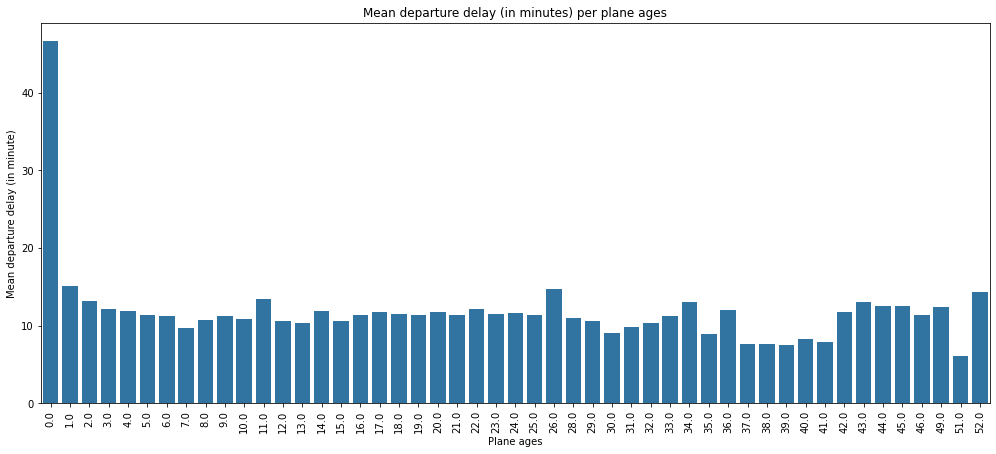

In [221]:
# Plot the mean departure delay per plane ages

plt.figure(figsize=[17,7])

sb.barplot(data=depdelays_per_planeage,x="PlaneAge",y="MeanDepDelay", color=sb.color_palette()[0])

plt.xticks(rotation=90)

plt.xlabel("Plane ages")
plt.ylabel("Mean departure delay (in minute)")
plt.title("Mean departure delay (in minutes) per plane ages");

We can see that the mean departure delay for planes with 0 as age is so high. From the 1st year of a plane to the 52th year, departure delay know many variation, but is stable between a range starting from 05 and going to 15 years.

It is worth investigating why the mean departure delay is so high for planes of 0 age. 

💡*We will use the above plot and its findings in the explanatory analysis.*

The inconsistent variation in the mean departure delays per plane ages make us speculate that their is a weak correlation between the departure delay and the plane ages. We will confirm that by a correlation plot.

In [222]:
# Correlation of our variables
depdelays_per_planeage.corr()

,PlaneAge,MeanDepDelay,MeanCarrierDelay,MeanWeatherDelay,MeanNASDelay,MeanNASDelay,MeanLateAircraftDelay,OtherDelay
PlaneAge,1.000000,-0.314921,0.004241,0.095287,-0.099418,-0.099418,-0.442087,0.185598
MeanDepDelay,-0.314921,1.000000,0.702634,0.612621,0.900954,0.900954,0.930345,-0.968422
MeanCarrierDelay,0.004241,0.702634,1.000000,0.784475,0.613673,0.613673,0.477806,-0.748968
MeanWeatherDelay,0.095287,0.612621,0.784475,1.000000,0.592582,0.592582,0.348312,-0.664907
MeanNASDelay,-0.099418,0.900954,0.613673,0.592582,1.000000,1.000000,0.819264,-0.964878
MeanNASDelay,-0.099418,0.900954,0.613673,0.592582,1.000000,1.000000,0.819264,-0.964878
MeanLateAircraftDelay,-0.442087,0.930345,0.477806,0.348312,0.819264,0.819264,1.000000,-0.879984
OtherDelay,0.185598,-0.968422,-0.748968,-0.664907,-0.964878,-0.964878,-0.879984,1.000000


We will see the correlation in a heatmap for easier analysis.

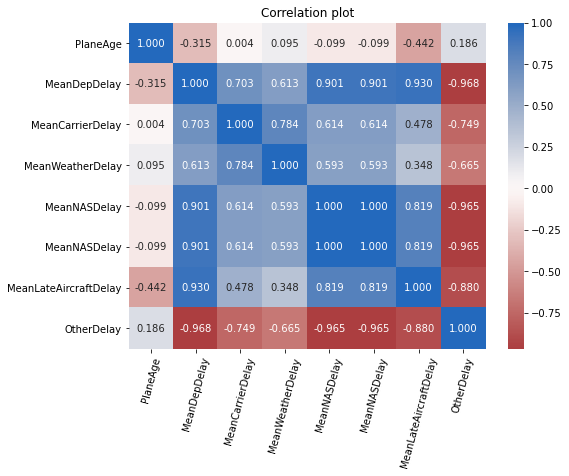

In [223]:
# Correlation plot of departure delays and departure reasons per planes age
plt.figure(figsize = [8, 6])
sb.heatmap(depdelays_per_planeage.corr(), annot = True, fmt = ".3f", cmap = "vlag_r", center = 0)
#plt.show()

plt.title("Correlation plot")

plt.xticks(rotation=75);

The correlation between `PlaneAge` and `MeanDepDelay` is -0.32. This is confirming that when the age of a plane is increasing, its departure delay tend to decrease.
However, the correlation is weak, as we speculated.

<div id="depdelay-vs-weather delays"></div>

### How well does weather predict plane delays?

The goal is to understand if a bad weather may implay a departure delays. Looking at our [Investigation of how weather delay impact departure delay](#weatherdelay-vs-depdelay), we can see that weather somehow impact the departure delay.

### Save dataset on disk

Save the dataset, so that we have it available during explanatory analysis

In [224]:
saved_datasets_folder="datasets/saved"

In [225]:
# Save to disk
clean_flight_df.to_csv("{}/clean_flight_df.csv".format(saved_datasets_folder),index=False)

In [226]:
# Load the exported file to make sure it was successfull
clean_flight_df2 = pd.read_csv("{}/clean_flight_df.csv".format(saved_datasets_folder))
clean_flight_df2

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,PlaneIssueDate,PlaneModel,PlaneStatus,AircraftType,PlaneEngine,PlaneCreationYear,PlaneAge,UniqueCarrierDesc,LiteralMonth,LiteralDayOfWeek
0,2005,1,28,5,1603,1605,1741,1759,UA,541,...,06/29/1992,737-522,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0,United Air Lines Inc.,Jan,Frid
1,2005,1,15,6,1733,1734,1909,1914,UA,557,...,06/29/1992,737-522,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0,United Air Lines Inc.,Jan,Sat
2,2005,1,19,3,807,805,912,910,UA,559,...,06/29/1992,737-522,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0,United Air Lines Inc.,Jan,Wed
3,2005,1,31,1,759,805,859,910,UA,559,...,06/29/1992,737-522,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0,United Air Lines Inc.,Jan,Mon
4,2005,1,19,3,1008,1010,1240,1258,UA,559,...,06/29/1992,737-522,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992.0,16.0,United Air Lines Inc.,Jan,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17014010,2008,1,4,5,845,810,914,844,AQ,267,...,07/08/2008,737-236,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1985.0,23.0,Aloha Airlines Inc.,Jan,Frid
17014011,2008,2,13,3,545,520,620,603,AQ,82,...,07/08/2008,737-236,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1985.0,23.0,Aloha Airlines Inc.,Feb,Wed
17014012,2008,2,19,2,2021,1955,2057,2038,AQ,86,...,07/08/2008,737-236,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1985.0,23.0,Aloha Airlines Inc.,Feb,Tue
17014013,2008,2,25,1,1416,1405,1502,1442,AQ,91,...,07/08/2008,737-236,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1985.0,23.0,Aloha Airlines Inc.,Feb,Mon


<div id="conclusion"></div>

[TOC](#intro)  
## Conclusions

A flight departure delay is related to two main factors:
* the months of the year: there are higher delays from December to March
* the weekdays: there are higher delay Thursday and Friday, closely followed by Sunday and Monday.


There are other factors impacting departure delays.                         
A plane, in its youth, has higher departure delay (while the delay is lower and stable from its 1st year to the end of its life).       
The departure city has high impact on weither the flight is taking-off on time or not.            
Departure delay has a positive correlatation to arrival delay.

We make some complementary discovering: 
* There is a high amount of flights all months around, and the number of flights is nearly the same from one month to another.
* The number of flights per weekdays is nearly the same, except on Saturday where the number is a litte less. And Saturday is also the day with the less departure delay.
* The most used plane is of type `Fixed Wing Multi-Engine`.


When doing the work, we encountered some limitations:
* We were not able to perform analysis related to cancellation, because all our flights have taken place.
* We saw that departure delays are related to city, and wanted to see which aspect of the cities (number of passengers of the plane, number of people living in the city, dimension big/small of the airport) are impacting the departure delay, but we don't have data which will allow that; 
* We had errors related to insufficiant RAM, so we were unable to answer some question. We hope that using Power BI or Tableau will solve this problem for us in the future.